### 1. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

### 2. Load Data

In [23]:
df = pd.read_csv('prosperLoanData.csv')
df_clean = df.copy()
df_clean.head()

In [161]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

##### 2.1. `ListingCreationDate`

- required: year, month, day
- optional: hour, minute, second, millisecond, microsecond, nanosecond

In [40]:
pd.to_datetime(df_clean['ListingCreationDate']).dt.time.head()

0    19:09:29.263000
1    08:28:07.900000
2    15:00:47.090000
3    11:02:35.010000
4    18:38:39.097000
Name: ListingCreationDate, dtype: object

- Há registro que a data está faltando 

##### 2.2. `CreditGrade`

In [3]:
last_date = pd.to_datetime(df_clean[df_clean['CreditGrade'].notna()]['ListingCreationDate']).max()
last_date

Timestamp('2009-05-04 13:07:15.977000')

- De acordo com a documentação, a última data que contém um valor não nulo para esta variável é em 2009.

In [52]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['CreditGrade'].unique()

array([nan], dtype=object)

In [46]:
df_clean[df_clean['CreditGrade'].notna()]['CreditGrade'].unique()

array(['C', 'HR', 'AA', 'D', 'B', 'E', 'A', 'NC'], dtype=object)

- Após 2009-05-04, o campo `CreditGrade` não foi mais preenchido. Enquanto que antes desta data, o campo foi preenchido.

##### 2.2. `Term`

In [53]:
df_clean['Term'].unique()

array([36, 60, 12], dtype=int64)

##### 2.3. `LoanStatus`

In [55]:
df_clean['LoanStatus'].unique()

array(['Completed', 'Current', 'Past Due (1-15 days)', 'Defaulted',
       'Chargedoff', 'Past Due (16-30 days)', 'Cancelled',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

##### 2.4. `ClosedDate`

In [64]:
df_clean[~df_clean['LoanStatus'].isin(['Cancelled', 'Completed', 'Chargedoff', 'Defaulted'])]['LoanStatus'].unique()

array(['Current', 'Past Due (1-15 days)', 'Past Due (16-30 days)',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

- Closed date is applicable for `Cancelled`, `Completed`, `Chargedoff` and `Defaulted` loan statuses.

##### 2.5. `BorrowerAPR` and `BorrowerRate`

In [144]:
df_clean['BorrowerAPR'].mean()

0.218827655909788

In [102]:
df_clean.loc[df_clean['BorrowerAPR'].isna(),['BorrowerAPR','BorrowerRate']].mean()

BorrowerAPR          NaN
BorrowerRate    0.091458
dtype: float64

- A média de `BorrowerRate` que possuem `BorrowerAPR` nulos é menor que os não nulos

In [147]:
df_clean.loc[df_clean['BorrowerAPR'] < df_clean['BorrowerRate'],['BorrowerAPR','BorrowerRate']]

,BorrowerAPR,BorrowerRate


- Todos os registros possuem o valor de `BorrowerAPR` maior que `BorrowerRate`.

In [149]:
df_clean['BorrowerAPR'].min(),df_clean['BorrowerAPR'].max()

(0.006529999999999999, 0.5122899999999999)

In [150]:
df_clean['BorrowerRate'].min(),df_clean['BorrowerRate'].max()

(0.0, 0.4975)

##### 2.6. `LenderYield`

In [4]:
df_clean['ServicingFee'] = df_clean['BorrowerRate'] - df_clean['LenderYield']

In [168]:
df_clean['ServicingFee'].min(),df_clean['ServicingFee'].max(),df_clean['ServicingFee'].mean()

(0.0, 0.05500000000000002, 0.010063095833655744)

- The `LenderYield` on the loan. `LenderYield` is equal to the interest rate on the loan less the servicing fee.

##### 2.7. `EstimatedEffectiveYield`

 - Effective yield is equal to the borrower interest rate (i) minus the servicing fee rate, (ii) minus estimated uncollected interest on charge-offs, (iii) plus estimated collected late fees. Applicable for loans originated after July 2009.

In [173]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) < last_date]['EstimatedEffectiveYield']

array([nan])

In [175]:
df_clean['EstimatedEffectiveYield'].min(),df_clean['EstimatedEffectiveYield'].max()

(-0.1827, 0.3199)

In [189]:
df_clean[df_clean['EstimatedEffectiveYield'] > 0][['BorrowerRate','ServicingFee','LenderYield','EstimatedEffectiveYield']].head()

,BorrowerRate,ServicingFee,LenderYield,EstimatedEffectiveYield
1,0.0920,0.01,0.0820,0.07960
3,0.0974,0.01,0.0874,0.08490
4,0.2085,0.01,0.1985,0.18316
5,0.1314,0.01,0.1214,0.11567
6,0.2712,0.01,0.2612,0.23820


- Há valores negativos, ainda não sei se isso tem lógica. Os dados faltantes são para os registros realizados até 2009.

##### 2.8. `EstimatedLoss`

In [193]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['EstimatedLoss'].head()

1    0.0249
3    0.0249
4    0.0925
5    0.0449
6    0.1275
Name: EstimatedLoss, dtype: float64

In [194]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['EstimatedLoss'].min()

0.0049

In [195]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['EstimatedLoss'].max()

0.366

In [5]:
fields = ['BorrowerRate','ServicingFee','LenderYield','EstimatedLoss','EstimatedEffectiveYield']
df_clean[df_clean['EstimatedEffectiveYield'] < 0][fields].head(10)

,BorrowerRate,ServicingFee,LenderYield,EstimatedLoss,EstimatedEffectiveYield
501,0.2100,0.01,0.2000,0.190,-0.0013
527,0.3269,0.01,0.3169,0.366,-0.0677
760,0.2000,0.01,0.1900,0.180,-0.0006
1321,0.3390,0.01,0.3290,0.345,-0.0354
1349,0.3500,0.01,0.3400,0.345,-0.0251
3686,0.3490,0.01,0.3390,0.366,-0.0470
4310,0.3100,0.01,0.3000,0.366,-0.0836
4491,0.3400,0.01,0.3300,0.366,-0.0555
4530,0.3089,0.01,0.2989,0.345,-0.0636
5760,0.3500,0.01,0.3400,0.345,-0.0251


##### 2.9. `EstimatedReturn`

In [6]:
df_clean = df_clean.round(4)

- Limitando para 4 casas decimais.

In [5]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['EstimatedReturn'].min()

-0.1827

- Mínimo valor negativo. Ainda não sei o que significa. Acho que não poderia ter valores negativos.

In [213]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['EstimatedReturn'].max()

0.2837

In [7]:
df_clean['EstRetCalc'] = df_clean['EstimatedEffectiveYield']- df_clean['EstimatedLoss']

- Recalculando o valor de `EstimatedLoss` para conferir se cálculo foi realizado corretamente.

In [9]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date][['EstimatedReturn','EstRetCalc']].head()

,EstimatedReturn,EstRetCalc
1,0.05470,0.05470
3,0.06000,0.06000
4,0.09066,0.09066
5,0.07077,0.07077
6,0.11070,0.11070


In [41]:
df_clean[(df_clean['EstimatedReturn'] != df_clean['EstRetCalc']) & \
         (df_clean['EstimatedReturn'].notna())][['EstimatedEffectiveYield','EstimatedLoss','EstimatedReturn','EstRetCalc']].head()

,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,EstRetCalc
27,0.0608,0.021,0.0608,0.0398
33,0.0555,0.013,0.0555,0.0425
91,0.1557,0.142,0.1557,0.0137
102,0.1024,0.021,0.1024,0.0814
109,0.0460,0.065,0.0460,-0.0190


In [8]:
temp = df_clean[(df_clean['EstimatedReturn'] != df_clean['EstRetCalc']) & \
         (df_clean['EstimatedReturn'].notna())][['EstimatedEffectiveYield','EstimatedLoss','EstimatedReturn','EstRetCalc','ListingCreationDate']]

In [52]:
temp[pd.to_datetime(temp['ListingCreationDate']) > last_date].head()

,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,EstRetCalc,ListingCreationDate
27,0.0608,0.021,0.0608,0.0398,2010-06-16 16:23:44.533000000
33,0.0555,0.013,0.0555,0.0425,2010-10-10 13:23:30.757000000
91,0.1557,0.142,0.1557,0.0137,2010-12-13 09:44:54.653000000
102,0.1024,0.021,0.1024,0.0814,2009-08-25 13:37:08.130000000
109,0.0460,0.065,0.0460,-0.0190,2009-09-02 03:17:56.993000000


In [42]:
df_clean[(df_clean['EstimatedReturn'] != df_clean['EstRetCalc']) & (df_clean['EstimatedReturn'] != df_clean['EstimatedReturn']) & \
         (df_clean['EstimatedReturn'].notna())][['EstimatedEffectiveYield','EstimatedLoss','EstimatedReturn','EstRetCalc']].head()

,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,EstRetCalc


 - `EstimatedReturn` possui alguns valores que não foram calculados corretamente, e quando isso ocorre a variável possui o memso valor de `EstimatedEffectiveYield`.

##### 2.10. `ProsperRating (numeric)`

In [82]:
df_clean['ProsperRating (numeric)'].head()

0    NaN
1    6.0
2    NaN
3    6.0
4    3.0
Name: ProsperRating (numeric), dtype: float64

- É uma variável que possui valores do tipo float e deveriam ser categóricos.

##### 2.11. `ProsperRating (Alpha)`

In [9]:
prosper_rating_dic = {
    "AA": 7.0,
    "A": 6.0,
    "B": 5.0,
    "C": 4.0,
    "D": 3.0,
    "E": 2.0,
    "HR": 1.0,
    np.NaN: 0}

In [85]:
df_clean['ProsperRating (Alpha)'].unique()

array([nan, 'A', 'D', 'B', 'E', 'C', 'AA', 'HR'], dtype=object)

In [57]:
df_clean[pd.to_datetime(df_clean['ListingCreationDate']) > last_date]['ProsperRating (Alpha)'].unique()

array(['A', 'D', 'B', 'E', 'C', 'AA', 'HR', nan], dtype=object)

In [10]:
temp = df_clean[['ProsperRating (Alpha)','ProsperRating (numeric)']]
temp['diff'] = df_clean['ProsperRating (Alpha)'].map(prosper_rating_dic) #== df_clean['ProsperRating (numeric)']

C:\Users\pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
temp[temp['ProsperRating (numeric)']== temp['diff']].head()

,ProsperRating (Alpha),ProsperRating (numeric),diff
1,A,6.0,6.0
3,A,6.0,6.0
4,D,3.0,3.0
5,B,5.0,5.0
6,E,2.0,2.0


In [94]:
temp[temp['ProsperRating (numeric)']!= temp['diff']]['ProsperRating (Alpha)'].unique()

array([nan], dtype=object)

- A correspondência entre as variáveis `ProsperRating (Alpha)` e `ProsperRating (numeric)` estão corretas, no entanto, em `ProsperRating (numeric)` há valores `NaN` que devem ser substituidos por `0`.

##### 2.12. `ProsperScore`

In [100]:
df_clean['ProsperScore'].min(),df_clean['ProsperScore'].max()

(1.0, 11.0)

In [104]:
df_clean['ProsperScore'].where(df_clean['ProsperScore'] > 10).count()

1456

- O valores deveriam variar entre 1 e 10. No entanto, há 1456 valores maiores que 10. Provavelmente foi erro de digitação, mas é necessário investigas mais.

##### 2.13. `ListingCategory`

In [110]:
df_clean['ListingCategory (numeric)'].min(),df_clean['ListingCategory (numeric)'].max()

(0, 20)

In [111]:
df_clean['ListingCategory (numeric)'].describe()

count    113937.000000
mean          2.774209
std           3.996797
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          20.000000
Name: ListingCategory (numeric), dtype: float64

- `ListingCategory` deve ser categórica.

##### 2.14. `BorrowerState`

In [113]:
df_clean['BorrowerState'].unique()

array(['CO', 'GA', 'MN', 'NM', 'KS', 'CA', 'IL', 'MD', nan, 'AL', 'AZ',
       'VA', 'FL', 'PA', 'OR', 'MI', 'NY', 'LA', 'WI', 'OH', 'NC', 'WA',
       'NV', 'NJ', 'TX', 'AR', 'SC', 'DE', 'MO', 'NE', 'UT', 'DC', 'MA',
       'CT', 'IN', 'KY', 'OK', 'MS', 'WV', 'RI', 'TN', 'ID', 'MT', 'HI',
       'NH', 'VT', 'WY', 'ME', 'AK', 'IA', 'SD', 'ND'], dtype=object)

In [6]:
temp = pd.read_csv('us_states.txt',sep="-", header=None,names=["state", "abbr"])
states_dict = dict(zip(temp['abbr'].str.strip(), temp['state'].str.strip()))
states_dict

{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DC': 'District of Columbia',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming

In [7]:
df_clean['BorrowerStateName'] = df_clean['BorrowerState'].map(states_dict)

In [8]:
df_clean[df_clean['BorrowerStateName'].isna()]['BorrowerState'].unique()

array([nan], dtype=object)

- `BorrowerState` tem os estados e o distrito federal dos Estados Unidos.

##### 2.15. `Occupation`

In [181]:
df_clean['Occupation'].unique()

array(['Other', 'Professional', 'Skilled Labor', 'Executive',
       'Sales - Retail', 'Laborer', 'Food Service', 'Fireman',
       'Waiter/Waitress', 'Construction', 'Computer Programmer',
       'Sales - Commission', 'Retail Management', 'Engineer - Mechanical',
       'Military Enlisted', 'Clerical', nan, 'Teacher', 'Clergy',
       'Accountant/CPA', 'Attorney', 'Nurse (RN)', 'Analyst',
       "Nurse's Aide", 'Investor', 'Realtor', 'Flight Attendant',
       'Nurse (LPN)', 'Military Officer', 'Food Service Management',
       'Truck Driver', 'Administrative Assistant',
       'Police Officer/Correction Officer', 'Social Worker',
       'Tradesman - Mechanic', 'Medical Technician', 'Professor',
       'Postal Service', 'Civil Service', 'Pharmacist',
       'Tradesman - Electrician', 'Scientist', 'Dentist',
       'Engineer - Electrical', 'Architect', 'Landscaping',
       'Tradesman - Carpenter', 'Bus Driver', 'Tradesman - Plumber',
       'Engineer - Chemical', 'Doctor', 'Chemist',


In [192]:
df_clean['Occupation'].isna().sum()

3588

- Há 3588 registros sem valores. Talvez não tivesse uma ocupação. O campo `Other` deveria ser usado em situações de ocupações não previstas e pelo visto não foi feito.

##### 2.16. `EmploymentStatus`

In [196]:
df_clean['EmploymentStatus'].unique()

array(['Self-employed', 'Employed', 'Not available', 'Full-time', 'Other',
       nan, 'Not employed', 'Part-time', 'Retired'], dtype=object)

In [197]:
df_clean['EmploymentStatus'].isna().sum()

2255

- Há 2255 registros sem valores. Talvez não tivesse uma emprego. O campo `Other` deveria ser usado em situações de ocupações não previstas e pelo visto não foi feito.

##### 2.17 `EmploymentStatusDuration`

In [200]:
df_clean['EmploymentStatusDuration'].min()

0.0

In [201]:
df_clean['EmploymentStatusDuration'].max()

755.0

In [203]:
df_clean['EmploymentStatusDuration'].isna().sum()

7625

In [205]:
df_clean[['Occupation','EmploymentStatus','EmploymentStatusDuration']].head()

,Occupation,EmploymentStatus,EmploymentStatusDuration
0,Other,Self-employed,2.0
1,Professional,Employed,44.0
2,Other,Not available,NaN
3,Skilled Labor,Employed,113.0
4,Executive,Employed,44.0


In [219]:
df_clean[df_clean['EmploymentStatus'].isna()][['Occupation','EmploymentStatus','EmploymentStatusDuration']].head()

,Occupation,EmploymentStatus,EmploymentStatusDuration
39,NaN,NaN,NaN
92,NaN,NaN,NaN
146,NaN,NaN,NaN
162,NaN,NaN,NaN
193,NaN,NaN,NaN


In [223]:
df_clean[df_clean['EmploymentStatus'].isna()]['Occupation'].unique()

array([nan], dtype=object)

In [234]:
df_clean[df_clean['EmploymentStatus'].isna()]['EmploymentStatusDuration'].value_counts(dropna=False)

NaN    2255
Name: EmploymentStatusDuration, dtype: int64

- `EmploymentStatus` com valor nulo também possuem `Occupation` e `EmploymentStatusDuration` com valores nulos. Poderia atribuir algum valor para eles, por exemplo, substituir `EmploymentStatus` nulo por `Not employed`, `Not available` ou `Other`.

In [233]:
df_clean[df_clean['EmploymentStatusDuration'].isna()]['EmploymentStatus'].value_counts(dropna=False)

Not available    5347
NaN              2255
Full-time          13
Other               6
Self-employed       2
Employed            1
Not employed        1
Name: EmploymentStatus, dtype: int64

In [239]:
df_clean[df_clean['EmploymentStatusDuration'].isna()]['Occupation'].value_counts(dropna=False).head()

NaN                    2261
Other                  1533
Professional            595
Clerical                303
Computer Programmer     260
Name: Occupation, dtype: int64

In [235]:
df_clean[df_clean['Occupation'].isna()]['EmploymentStatus'].value_counts(dropna=False)

NaN          2255
Other        1332
Full-time       1
Name: EmploymentStatus, dtype: int64

In [237]:
df_clean[df_clean['Occupation'].isna()]['EmploymentStatusDuration'].value_counts(dropna=False).head()

NaN     2261
0.0      574
1.0       26
12.0      13
8.0       10
Name: EmploymentStatusDuration, dtype: int64

- `Occupation` com valor nulo deve ser substituído por `Other`.
- `EmploymentStatus`com valor nulo deve ser substituído por `Other` ou `Not available`. Há um registro como `Full-time`, talvez seja melhor substituir ele também.

##### 2.18. `IsBorrowerHomeowner`

In [5]:
df_clean['IsBorrowerHomeowner'].unique()

array([ True, False])

In [7]:
df_clean[df_clean['IsBorrowerHomeowner'].isna()]

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors


##### 2.19. `CurrentlyInGroup`

In [9]:
df_clean['CurrentlyInGroup'].unique()

array([ True, False])

In [10]:
df_clean[df_clean['CurrentlyInGroup'].isna()]

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors


##### 2.20. `GroupKey`

In [12]:
df_clean['GroupKey'].head()

0                        NaN
1                        NaN
2    783C3371218786870A73D20
3                        NaN
4                        NaN
Name: GroupKey, dtype: object

In [14]:
df[['CurrentlyInGroup','GroupKey']].head()

,CurrentlyInGroup,GroupKey
0,True,NaN
1,False,NaN
2,True,783C3371218786870A73D20
3,False,NaN
4,False,NaN


- Há registros com `CurrentlyInGroup` com `True` mas não possuem o valor da chave em `GroupKey`.

##### 2.21. `DateCreditPulled`

In [86]:
df_clean['DateCreditPulled'].head()

0   2007-08-26 18:41:46.780
1   2014-02-27 08:28:14.000
2   2007-01-02 14:09:10.060
3   2012-10-22 11:02:32.000
4   2013-09-14 18:38:44.000
Name: DateCreditPulled, dtype: datetime64[ns]

In [17]:
df_clean['DateCreditPulled'].describe()

count                  113937
unique                 112992
top       2013-12-23 09:38:12
freq                        6
Name: DateCreditPulled, dtype: object

- `DateCreditPulled` deve ser datetime

In [18]:
df_clean['DateCreditPulled'].isna().sum()

0

- Não há valores nulos.

In [14]:
df_clean['DateCreditPulled'] = pd.to_datetime(df_clean['DateCreditPulled'])
df_clean['ListingCreationDate'] = pd.to_datetime(df_clean['ListingCreationDate'])

In [22]:
df_clean['DateCreditPulled'].min(),df_clean['DateCreditPulled'].max()

(Timestamp('2005-11-09 00:30:04.487000'), Timestamp('2014-03-10 12:20:56'))

In [27]:
df_clean[['ListingCreationDate','DateCreditPulled']].head()

,ListingCreationDate,DateCreditPulled
0,2007-08-26 19:09:29.263,2007-08-26 18:41:46.780
1,2014-02-27 08:28:07.900,2014-02-27 08:28:14.000
2,2007-01-05 15:00:47.090,2007-01-02 14:09:10.060
3,2012-10-22 11:02:35.010,2012-10-22 11:02:32.000
4,2013-09-14 18:38:39.097,2013-09-14 18:38:44.000


- `DateCreditPulled` pode ser antes ou depois de `ListingCreationDate`.

In [33]:
(df_clean['ListingCreationDate'] > df_clean['DateCreditPulled']).sum()

85516

In [34]:
(df_clean['ListingCreationDate'] < df_clean['DateCreditPulled']).sum()

28198

In [35]:
(df_clean['ListingCreationDate'] == df_clean['DateCreditPulled']).sum()

223

In [39]:
df_clean['ListCreatDiffCreditPull'] = df_clean['ListingCreationDate'] - df_clean['DateCreditPulled']

- Saber se uma data deveria vir primeiro que a outra.

##### 2.22. `CreditScoreRangeLower`

In [42]:
df_clean['CreditScoreRangeLower'].min(),df_clean['CreditScoreRangeLower'].max()

(0.0, 880.0)

In [ ]:
df_clean['CreditScoreRangeLower'].isna().sum()

##### 2.23. `CreditScoreRangeUpper`

In [46]:
df_clean['CreditScoreRangeUpper'].min(),df_clean['CreditScoreRangeUpper'].max()

(19.0, 899.0)

In [47]:
df_clean['CreditScoreRangeUpper'].isna().sum()

591

In [51]:
(df_clean['CreditScoreRangeLower'].isna() & df_clean['CreditScoreRangeUpper'].isna()).sum()

591

In [48]:
(df_clean['CreditScoreRangeUpper'] < df_clean['CreditScoreRangeLower']).sum()

0

- Não há valor `CreditScoreRangeLower` maior que `CreditScoreRangeUpper` para o mesmo registro.

##### 2.24. `FirstRecordedCreditLine`

In [12]:
df_clean['FirstRecordedCreditLine'] = pd.to_datetime(df_clean['FirstRecordedCreditLine'])

In [90]:
df_clean['FirstRecordedCreditLine'].min()

Timestamp('1947-08-24 00:00:00')

In [92]:
df_clean['FirstRecordedCreditLine'].nsmallest(10)

45245    1947-08-24
8107     1950-08-01
32778    1951-01-01
49552    1951-01-01
70711    1951-07-04
94308    1951-07-04
6343     1953-01-13
107533   1953-01-13
24820    1953-09-01
83835    1953-09-01
Name: FirstRecordedCreditLine, dtype: datetime64[ns]

In [56]:
(df_clean['FirstRecordedCreditLine'] < df_clean['ListingCreationDate']).sum()

113240

In [58]:
df_clean[df_clean['FirstRecordedCreditLine'] < df_clean['ListingCreationDate']][['FirstRecordedCreditLine','ListingCreationDate']].head()

,FirstRecordedCreditLine,ListingCreationDate
0,2001-10-11,2007-08-26 19:09:29.263
1,1996-03-18,2014-02-27 08:28:07.900
2,2002-07-27,2007-01-05 15:00:47.090
3,1983-02-28,2012-10-22 11:02:35.010
4,2004-02-20,2013-09-14 18:38:39.097


In [54]:
df_clean['FirstRecordedCreditLine'].isna().sum()

697

In [59]:
(df_clean['CreditScoreRangeUpper'].isna() & df_clean['FirstRecordedCreditLine'].isna()).sum()

591

##### 2.25. `OpenCreditLines`

In [64]:
df_clean['OpenCreditLines'].max()

54.0

In [66]:
df_clean['OpenCreditLines'].describe()

count    106333.000000
mean          9.260164
std           5.022644
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max          54.000000
Name: OpenCreditLines, dtype: float64

In [67]:
(df_clean['OpenCreditLines'] > 50).sum()

2

- `OpenCreditLines` igual a 54 parece ser muito alto. Investigar mais.
- Deveria ter valores inteiros.

In [63]:
df_clean['OpenCreditLines'].isna().sum()

7604

- Valores nulos poderiam ser substituídos por 0. Investigar mais.

##### 2.26. `TotalCreditLinespast7years`

In [69]:
df_clean['TotalCreditLinespast7years'].head()

0    12.0
1    29.0
2     3.0
3    29.0
4    49.0
Name: TotalCreditLinespast7years, dtype: float64

- Deve ser inteiro.

In [71]:
df_clean['TotalCreditLinespast7years'].min(),df_clean['TotalCreditLinespast7years'].max()

(2.0, 136.0)

In [72]:
df_clean['TotalCreditLinespast7years'].isna().sum()

697

In [73]:
(df_clean['FirstRecordedCreditLine'].isna() & df_clean['TotalCreditLinespast7years'].isna()).sum()

697

- Quem não tem nenhuma linha de crédito nos últimos 7 anos não possui o registo na base de dados. Porém, há a data em `FirstRecordedCreditLine` da primeira linha de crédito realizada.

##### 2.27. `OpenRevolvingAccounts`

In [87]:
df_clean['OpenRevolvingAccounts'].isna().sum()

0

In [88]:
df_clean['OpenRevolvingAccounts'].min(),df_clean['OpenRevolvingAccounts'].max()

(0, 51)

In [93]:
df_clean['OpenRevolvingAccounts'].describe()

count    113937.00000
mean          6.96979
std           4.63097
min           0.00000
25%           4.00000
50%           6.00000
75%           9.00000
max          51.00000
Name: OpenRevolvingAccounts, dtype: float64

In [98]:
df_clean['OpenRevolvingAccounts'].nlargest(10)

73700     51
98300     50
89656     49
40003     47
66650     47
80844     46
112141    46
17057     44
22514     41
27843     41
Name: OpenRevolvingAccounts, dtype: int64

##### 2.28. `InquiriesLast6Months`

In [100]:
df_clean['InquiriesLast6Months'].min(),df_clean['InquiriesLast6Months'].max()

(0.0, 105.0)

- Deve ser inteiro.

In [103]:
df_clean['InquiriesLast6Months'].describe()

count    113240.000000
mean          1.435085
std           2.437507
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         105.000000
Name: InquiriesLast6Months, dtype: float64

In [105]:
df_clean['InquiriesLast6Months'].nlargest(10)

95293     105.0
63578      97.0
51812      63.0
99929      53.0
81528      52.0
111901     50.0
70788      46.0
191        44.0
45960      44.0
589        42.0
Name: InquiriesLast6Months, dtype: float64

- Há 2 valoers bem superior aos demais (105 e 97), será que são outliers? Como identificar isso?

In [114]:
df_clean['InquiriesLast6Months'].isna().sum()

697

In [115]:
(df_clean['FirstRecordedCreditLine'].isna() & df_clean['InquiriesLast6Months'].isna()).sum()

697

- Os mesmos registros que possuem valores nulos em `FirstRecordedCreditLine` também são os mesmos em `InquiriesLast6Months`

##### 2.29. `TotalInquiries`

In [102]:
df_clean['TotalInquiries'].min(),df_clean['TotalInquiries'].max()

(0.0, 379.0)

- Deve ser inteiro.

In [106]:
df_clean['TotalInquiries'].describe()

count    112778.000000
mean          5.584405
std           6.429946
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         379.000000
Name: TotalInquiries, dtype: float64

In [113]:
df_clean['TotalInquiries'].isna().sum()

1159

- Esses valores deveriam ser substituídos por zero, por outro valor ou apenas deixá-los como estão?

In [119]:
(df_clean['FirstRecordedCreditLine'].isna() & df_clean['TotalInquiries'].isna()).sum()

598

- 598 registros que possuem valores nulos em `TotalInquiries` também são os mesmos em `InquiriesLast6Months` e `FirstRecordedCreditLine`.

In [116]:
df_clean['TotalInquiries'].nlargest(10)

63578     379.0
95293     377.0
111901    158.0
589       117.0
16239     113.0
52113     112.0
30011     109.0
34720     109.0
33785     106.0
78859     105.0
Name: TotalInquiries, dtype: float64

- Há dois valores (379 e 377) que são bem maiores que demais valores, podem ser outliers. 

##### 2.30. `CurrentDelinquencies`

In [117]:
df_clean['CurrentDelinquencies'].min(),df_clean['CurrentDelinquencies'].max()

(0.0, 83.0)

In [110]:
df_clean['CurrentDelinquencies'].describe()

count    113240.000000
mean          0.592052
std           1.978707
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          83.000000
Name: CurrentDelinquencies, dtype: float64

In [118]:
df_clean['CurrentDelinquencies'].isna().sum()

697

In [120]:
(df_clean['FirstRecordedCreditLine'].isna() & df_clean['CurrentDelinquencies'].isna()).sum()

697

- Os registros que possuem valores nulos em `CurrentDelinquencies` também são os mesmos em `InquiriesLast6Months` e `FirstRecordedCreditLine`.

In [111]:
df_clean['CurrentDelinquencies'].nlargest(10)

93964     83.0
94863     82.0
28604     64.0
35284     59.0
44476     57.0
109208    51.0
40759     50.0
62461     45.0
11901     41.0
83362     41.0
Name: CurrentDelinquencies, dtype: float64

##### 2.31. `AmountDelinquent`

In [122]:
df_clean['AmountDelinquent'].min(),df_clean['AmountDelinquent'].max()

(0.0, 463881.0)

In [123]:
df_clean['AmountDelinquent'].describe()

count    106315.000000
mean        984.507059
std        7158.270157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      463881.000000
Name: AmountDelinquent, dtype: float64

In [124]:
df_clean['AmountDelinquent'].nlargest(10)

70276    463881.0
52036    444745.0
17273    327677.0
96719    284169.0
34294    279970.0
50320    265084.0
19542    255963.0
35509    249209.0
16417    242333.0
90235    241707.0
Name: AmountDelinquent, dtype: float64

In [131]:
(df_clean['AmountDelinquent'] > 0).sum()

16497

In [132]:
df_clean['AmountDelinquent'].isna().sum()

7622

- Há 7622 valores nulos. Podem ser substituídos por 0 ou por outro valor?

##### 2.32. `DelinquenciesLast7Years`

In [135]:
df_clean['DelinquenciesLast7Years'].min(),df_clean['DelinquenciesLast7Years'].max()

(0.0, 99.0)

In [137]:
df_clean['DelinquenciesLast7Years'].describe()

count    112947.000000
mean          4.154984
std          10.160216
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          99.000000
Name: DelinquenciesLast7Years, dtype: float64

- Parecem ser outlier.

In [136]:
df_clean['DelinquenciesLast7Years'].isna().sum()

990

In [140]:
(df_clean['DelinquenciesLast7Years'].isna() & df_clean['AmountDelinquent'].isna()).sum()

990

##### 2.33. `PublicRecordsLast10Years`

In [15]:
df_clean['PublicRecordsLast10Years'].min(),df_clean['PublicRecordsLast10Years'].max()

(0.0, 38.0)

In [16]:
df_clean['PublicRecordsLast10Years'].isna().sum()

697

In [33]:
df_clean[df_clean['FirstRecordedCreditLine'].isna()][['PublicRecordsLast10Years','CurrentDelinquencies','FirstRecordedCreditLine']].head()

,PublicRecordsLast10Years,CurrentDelinquencies,FirstRecordedCreditLine
206,NaN,NaN,NaT
387,NaN,NaN,NaT
698,NaN,NaN,NaT
794,NaN,NaN,NaT
802,NaN,NaN,NaT


- `PublicRecordsLast10Years` que são nulos, são os mesmos de `CurrentDelinquencies` e `FirstRecordedCreditLine`.

In [24]:
df_clean['FirstRecordedCreditLine'].isna()

697

##### 2.34. `PublicRecordsLast12Months`

In [36]:
df['PublicRecordsLast12Months'].max()

20.0

In [40]:
df['PublicRecordsLast12Months'].nlargest(5)

48338    20.0
20857     7.0
95437     7.0
27637     4.0
32291     4.0
Name: PublicRecordsLast12Months, dtype: float64

- Há o um registro com o valor de 20. É um valor muito alto para se ter em apenas 12 meses. 
- Deve ser inteiro.

##### 2.35. `RevolvingCreditBalance`

In [44]:
df_clean['RevolvingCreditBalance'].nlargest(10)

62274     1435667.0
40276     1433328.0
84331      999165.0
32026      976426.0
82977      913922.0
100801     879891.0
16662      879785.0
12857      878859.0
112431     877847.0
40951      875255.0
Name: RevolvingCreditBalance, dtype: float64

In [45]:
df_clean['RevolvingCreditBalance'].isna().sum()

7604

- Investigar os valores mais altos, será que eles tem algum padrão? Os valores nulos podem ser substituídos por algum outro valor?

##### 2.36 `BankcardUtilization`

In [76]:
(df_clean['BankcardUtilization'] > 1).sum()

1744

- Há valores maiores que 100%, o que significa que estão errados. É necessário uma investigação maior para identificar se considerando apenas as casas decimais é o suficiente.

In [77]:
df_clean['BankcardUtilization'].isna().sum()

7604

##### 2.37. `AvailableBankcardCredit`

In [82]:
df_clean['AvailableBankcardCredit'].nlargest(10)

24916     646285.0
93897     572427.0
105754    566480.0
80178     498374.0
39804     477656.0
38528     463575.0
92406     432613.0
98518     413367.0
39756     413072.0
99673     412785.0
Name: AvailableBankcardCredit, dtype: float64

In [83]:
df_clean['AvailableBankcardCredit'].isna().sum()

7544

In [106]:
(df_clean['RevolvingCreditBalance'].isna() & df_clean['BankcardUtilization'].isna() & df_clean['AvailableBankcardCredit'].isna()).sum()

7544

In [111]:
df_clean[df_clean['RevolvingCreditBalance'].isna() & df_clean['BankcardUtilization'].isna() & df_clean['AvailableBankcardCredit'].isna()][['RevolvingCreditBalance','AvailableBankcardCredit','BankcardUtilization']].head()

,RevolvingCreditBalance,AvailableBankcardCredit,BankcardUtilization
2,NaN,NaN,NaN
17,NaN,NaN,NaN
39,NaN,NaN,NaN
42,NaN,NaN,NaN
63,NaN,NaN,NaN


- `AvailableBankcardCredit` que possui os valores nulos são os menos que em `RevolvingCreditBalance` e `BankcardUtilization`. Esses valores devem ser subtituídos por algum valor? Qual?

##### 2.38. `TotalTrades`

In [114]:
df_clean['TotalTrades'].max()

126.0

In [115]:
df_clean['TotalTrades'].nlargest(10)

80844     126.0
75941     122.0
111996    118.0
105625    114.0
51947     110.0
64147     108.0
38652     103.0
49385     103.0
7734      102.0
28042     102.0
Name: TotalTrades, dtype: float64

In [116]:
df_clean['TotalTrades'].isna().sum()

7544

In [117]:
(df_clean['TotalTrades'].isna() & df_clean['RevolvingCreditBalance'].isna() & df_clean['BankcardUtilization'].isna() & df_clean['AvailableBankcardCredit'].isna()).sum()

7544

##### 2.39 `TradesNeverDelinquent`

In [126]:
temp_list = ['TradesNeverDelinquent (percentage)','BankcardUtilization','RevolvingCreditBalance','AvailableBankcardCredit','TotalTrades']

In [122]:
df_clean['TradesNeverDelinquent (percentage)'].max()

1.0

In [124]:
df_clean['TradesNeverDelinquent (percentage)'].isna().sum()

7544

In [129]:
(df_clean[temp_list].isna()).sum()

TradesNeverDelinquent (percentage)    7544
BankcardUtilization                   7604
RevolvingCreditBalance                7604
AvailableBankcardCredit               7544
TotalTrades                           7544
dtype: int64

##### 2.40. `TradesOpenedLast6Months`

In [133]:
df_clean['TradesOpenedLast6Months'].nlargest(10)

11266     20.0
7984      17.0
33814     17.0
5932      16.0
57837     15.0
113692    15.0
30078     14.0
68339     14.0
5228      13.0
43621     13.0
Name: TradesOpenedLast6Months, dtype: float64

In [135]:
df['TradesOpenedLast6Months'].isna().sum()

7544

In [136]:
temp_list.append('TradesOpenedLast6Months')

In [139]:
(df_clean[df_clean['TradesOpenedLast6Months'].isna()][temp_list].isna()).sum()

TradesNeverDelinquent (percentage)    7544
BankcardUtilization                   7544
RevolvingCreditBalance                7544
AvailableBankcardCredit               7544
TotalTrades                           7544
TradesOpenedLast6Months               7544
dtype: int64

##### 2.41. `DebtToIncomeRatio`

In [142]:
df_clean['DebtToIncomeRatio'].max()

10.01

In [143]:
df_clean['DebtToIncomeRatio'].isna().sum()

8554

##### 2.42. `IncomeRange`

In [146]:
df_clean['IncomeRange'].head()

0    $25,000-49,999
1    $50,000-74,999
2     Not displayed
3    $25,000-49,999
4         $100,000+
Name: IncomeRange, dtype: object

In [150]:
df_clean['IncomeRange'].isna().sum()

0

In [151]:
df_clean['IncomeRange'].unique()

array(['$25,000-49,999', '$50,000-74,999', 'Not displayed', '$100,000+',
       '$75,000-99,999', '$1-24,999', 'Not employed', '$0'], dtype=object)

- Seperar os valores minímos e máximos em variáveis diferentes.

##### 2.43. `IncomeVerifiable`

In [148]:
df_clean['IncomeVerifiable'].isna().sum()

0

In [149]:
df_clean['IncomeVerifiable'].unique()

array([ True, False])

##### 2.44. `StatedMonthlyIncome`

In [167]:
pd.options.display.float_format = '{:.2f}'.format

In [154]:
df_clean['StatedMonthlyIncome'].max()

1750002.916667

In [165]:
df_clean['StatedMonthlyIncome'].nlargest(10)

53167    1750002.92
53014     618547.83
17411     483333.33
57133     466666.67
8066      416666.67
113270    394400.00
82831     250000.00
8870      208333.33
56867     185081.75
83697     185081.75
Name: StatedMonthlyIncome, dtype: float64

- Há um valor muito maior que demais valores, investigar se este valor está condizendo com demais variáveis.

In [ ]:
temp_list.append('StatedMonthlyIncome')

In [180]:
df_clean.loc[df_clean['StatedMonthlyIncome'].idxmax()][temp_list]

TradesNeverDelinquent (percentage)         1.00
BankcardUtilization                        0.61
RevolvingCreditBalance                 42855.00
AvailableBankcardCredit                26168.00
TotalTrades                               33.00
TradesOpenedLast6Months                    0.00
StatedMonthlyIncome                  1750002.92
Name: 53167, dtype: object

##### 2.45. `LoanKey`

In [183]:
(df_clean['LoanKey'].duplicated()).sum()

871

- Há valores repetidos. 

In [ ]:
temp_list.append('LoanKey')

In [202]:
df_clean[df_clean['LoanKey'].duplicated(keep=False)].sort_values('LoanKey')[temp_list].head()

,TradesNeverDelinquent (percentage),BankcardUtilization,RevolvingCreditBalance,AvailableBankcardCredit,TotalTrades,TradesOpenedLast6Months,StatedMonthlyIncome,LoanKey
55674,0.86,0.36,17219.00,20033.00,22.00,2.00,6250.00,001D370202065948445765E
54740,0.86,0.36,17219.00,20033.00,22.00,2.00,6250.00,001D370202065948445765E
87726,1.00,0.21,8563.00,30847.00,36.00,1.00,3000.00,009C36959125842600757B0
21442,1.00,0.21,8563.00,30847.00,36.00,1.00,3000.00,009C36959125842600757B0
43779,1.00,0.46,27749.00,30103.00,28.00,0.00,5625.00,01663704101754715CF7C56


- Há 871 registros duplicados. Podem ser removidos.

##### 2.46. `TotalProsperLoans`

In [209]:
df_clean['TotalProsperLoans'].isna().sum()

91852

- Deve ser inteiro.

##### 2.47. `TotalProsperPaymentsBilled`

In [212]:
df_clean['TotalProsperPaymentsBilled'].max()

141.0

In [211]:
df_clean['TotalProsperPaymentsBilled'].isna().sum()

91852

- Deve ser inteiro.

##### 2.48. `OnTimeProsperPayments`

In [18]:
df_clean['OnTimeProsperPayments'].max()

141.0

In [19]:
df_clean['OnTimeProsperPayments'].nlargest()

106677    141.0
51501     134.0
75698     133.0
26348     132.0
1294      131.0
Name: OnTimeProsperPayments, dtype: float64

In [16]:
df_clean['OnTimeProsperPayments'].isna().sum()

91852

##### 2.49. `ProsperPaymentsLessThanOneMonthLate`

In [22]:
df_clean['ProsperPaymentsLessThanOneMonthLate'].max()

42.0

In [23]:
df_clean['ProsperPaymentsLessThanOneMonthLate'].isna().sum()

91852

- Deve ser inteiro.

##### 2.50. `ProsperPaymentsOneMonthPlusLate`

In [27]:
df_clean['ProsperPaymentsOneMonthPlusLate'].isna().sum()

91852

In [29]:
df_clean['ProsperPaymentsOneMonthPlusLate'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    0.0
Name: ProsperPaymentsOneMonthPlusLate, dtype: float64

- Deve ser inteiro.

##### 2.51. `ProsperPrincipalBorrowed`

In [32]:
df_clean['ProsperPrincipalBorrowed'].max()

72499.0

In [34]:
df_clean['ProsperPrincipalBorrowed'].nlargest(10)

22513     72499.00
93000     67000.00
92030     65000.00
53334     63000.00
106335    62999.00
3399      62000.00
86593     60001.00
58380     60000.00
37062     57582.57
3071      57499.00
Name: ProsperPrincipalBorrowed, dtype: float64

In [33]:
df_clean['ProsperPrincipalBorrowed'].isna().sum()

91852

##### 2.52. `ProsperPrincipalOutstanding`

In [37]:
df_clean['ProsperPrincipalOutstanding'].max()

23450.95

In [38]:
df_clean['ProsperPrincipalOutstanding'].isna().sum()

91852

##### 2.53. `ScorexChangeAtTimeOfListing`

In [42]:
df_clean['ScorexChangeAtTimeOfListing'].isna().sum()

95009

In [43]:
df_clean[df_clean['ProsperPrincipalOutstanding'].isna()]['ScorexChangeAtTimeOfListing'].isna().sum()

91852

In [47]:
df_clean[~df_clean['ScorexChangeAtTimeOfListing'].isna()]['ScorexChangeAtTimeOfListing'].head()

16    -19.0
33    161.0
46      0.0
47     14.0
54     59.0
Name: ScorexChangeAtTimeOfListing, dtype: float64

##### 2.54. `LoanCurrentDaysDelinquent`

In [52]:
df_clean['LoanCurrentDaysDelinquent'].isna().sum()

0

##### 2.55. `LoanFirstDefaultedCycleNumber`

In [55]:
df_clean['LoanFirstDefaultedCycleNumber'].max()

44.0

In [3]:
df_clean['LoanFirstDefaultedCycleNumber'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: LoanFirstDefaultedCycleNumber, dtype: float64

In [4]:
df_clean['LoanFirstDefaultedCycleNumber'].isna().sum()

96985

In [8]:
df_clean[df_clean['LoanFirstDefaultedCycleNumber'].isna()]['ScorexChangeAtTimeOfListing'].isna().sum()

80485

In [7]:
df_clean[df_clean['LoanFirstDefaultedCycleNumber'].isna()]['ProsperPrincipalOutstanding'].isna().sum()

77330

- Deve haver uma relação entre `LoanFirstDefaultedCycleNumber`, `ProsperPrincipalOutstanding` e `ScorexChangeAtTimeOfListing`.

##### 2.56. `LoanMonthsSinceOrigination`

In [12]:
df_clean['LoanMonthsSinceOrigination'].max()

100

##### 2.57. `LoanNumber`

In [16]:
df_clean['LoanNumber'].isna().sum()

0

In [20]:
df_clean['LoanNumber'].duplicated().sum()

871

- Tem a mesma quantidade de valores repetidos que `LoanKey`.

In [29]:
set(df_clean[df_clean['LoanKey'].duplicated()].index) == set(df_clean[df_clean['LoanNumber'].duplicated()].index)

True

- Há chaves duplicadas e são as mesmas de `LoadKey`.

##### 2.58. `LoanOriginalAmount`

In [35]:
df_clean['LoanOriginalAmount'].isna().sum()

0

##### 2.59. `LoanOriginationDate`

In [37]:
df_clean['LoanOriginationDate'].describe()

count                  113937
unique                   1873
top       2014-01-22 00:00:00
freq                      491
Name: LoanOriginationDate, dtype: object

In [43]:
df_clean['LoanOriginationDate'] = pd.to_datetime(df_clean['LoanOriginationDate'])

In [44]:
df_clean['FirstRecordedCreditLine'] =  pd.to_datetime(df_clean['FirstRecordedCreditLine'])
df_clean['ListingCreationDate'] =  pd.to_datetime(df_clean['ListingCreationDate'])
df_clean['ClosedDate'] =  pd.to_datetime(df_clean['ClosedDate'])

In [51]:
(df_clean['FirstRecordedCreditLine'] < df_clean['LoanOriginationDate']).sum()

113240

In [53]:
(df_clean['ClosedDate'] < df_clean['LoanOriginationDate']).sum()

2

In [54]:
(df_clean['ListingCreationDate'] < df_clean['LoanOriginationDate']).sum()

113937

##### 2.60. `LoanOriginationQuarter`

In [56]:
df_clean['LoanOriginationQuarter'].head()

0    Q3 2007
1    Q1 2014
2    Q1 2007
3    Q4 2012
4    Q3 2013
Name: LoanOriginationQuarter, dtype: object

In [58]:
df_clean[['LoanOriginationQuarter','LoanOriginationDate']].head()

,LoanOriginationQuarter,LoanOriginationDate
0,Q3 2007,2007-09-12
1,Q1 2014,2014-03-03
2,Q1 2007,2007-01-17
3,Q4 2012,2012-11-01
4,Q3 2013,2013-09-20


- A informaçã do ano já está em `LoanOriginationDate`, então é desnecessário manter essa informação. 

- Transformar esta variável em categórica.

##### 2.61. `MemberKey`

##### 2.62. `MonthlyLoanPayment`

In [73]:
df_clean['MonthlyLoanPayment'].isna().sum()

0

In [75]:
df_clean['MonthlyLoanPayment'].max()

2251.51

##### 2.63. `LP_CustomerPayments`

In [81]:
df_clean['LP_CustomerPayments'].nsmallest()

28384   -2.3499
1        0.0000
34       0.0000
65       0.0000
86       0.0000
Name: LP_CustomerPayments, dtype: float64

- Corrigir valor negativo.

In [82]:
df_clean['LP_CustomerPayments'].nlargest()

109046    40702.39
70409     40547.70
39999     38249.01
111551    38227.19
13882     38206.09
Name: LP_CustomerPayments, dtype: float64

##### 2.64. `LP_CustomerPrincipalPayments`

In [86]:
df_clean['LP_CustomerPrincipalPayments'].isna().sum()

0

##### 2.65. `LP_InterestandFees`

In [89]:
df_clean['LP_InterestandFees'].nsmallest()

28384   -2.3499
91184   -0.0034
1        0.0000
34       0.0000
65       0.0000
Name: LP_InterestandFees, dtype: float64

- Corrigir valor negativo.

##### 2.66. `LP_ServiceFees`

In [95]:
df_clean['LP_ServiceFees'].head()

0   -133.18
1      0.00
2    -24.20
3   -108.01
4    -60.27
Name: LP_ServiceFees, dtype: float64

- Valores devem ser positivos.

##### 2.67. `LP_CollectionFees`

In [100]:
df_clean['LP_CollectionFees'].min()

-9274.75

- Converter os valores para positivos.

##### 2.68. `LP_GrossPrincipalLoss`

In [104]:
df_clean['LP_GrossPrincipalLoss'].nsmallest()

34787   -94.2
0         0.0
1         0.0
2         0.0
3         0.0
Name: LP_GrossPrincipalLoss, dtype: float64

- Corrgir valor negativo.

##### 2.69. `LP_NetPrincipalLoss`

In [108]:
df_clean['LP_NetPrincipalLoss'].nsmallest()

36656   -954.55
83346   -774.11
84549   -504.41
46051   -474.32
97179   -437.68
Name: LP_NetPrincipalLoss, dtype: float64

- Corrigir valor para positivo.

In [109]:
df_clean['LP_NetPrincipalLoss'].nlargest()

1171     25000.0
4135     25000.0
34662    25000.0
47242    25000.0
51428    25000.0
Name: LP_NetPrincipalLoss, dtype: float64

In [110]:
df_clean['LP_NetPrincipalLoss'].isna().sum()

0

##### 2.70. `LP_NonPrincipalRecoverypayments`

In [116]:
df_clean['LP_NonPrincipalRecoverypayments'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: LP_NonPrincipalRecoverypayments, dtype: float64

##### 2.71. `PercentFunded`

In [126]:
df_clean['PercentFunded'].min()

0.7

In [124]:
df_clean['PercentFunded'].nlargest(5)

112425    1.0125
103509    1.0110
8991      1.0045
0         1.0000
1         1.0000
Name: PercentFunded, dtype: float64

- O valor devia varia entre 0 e 1, há valores maiores que 1.

##### 2.72. `Recommendations`

In [130]:
df_clean['Recommendations'].nlargest()

14716     39
80738     24
15545     21
94485     19
106650    18
Name: Recommendations, dtype: int64

In [132]:
df_clean['Recommendations'].isna().sum()

0

##### 2.73. `InvestmentFromFriendsCount`

In [136]:
df_clean['InvestmentFromFriendsCount'].isna().sum()

0

In [147]:
df_clean['InvestmentFromFriendsCount'].head()

0    0
1    0
2    0
3    0
4    0
Name: InvestmentFromFriendsCount, dtype: int64

##### 2.74. `InvestmentFromFriendsAmount`

In [151]:
df_clean['InvestmentFromFriendsAmount'].isna().sum()

0

##### 2.75. `Investors`

In [156]:
df_clean['Investors'].nlargest()

89166    1189
53427    1035
28107    1024
77068    1011
16086     917
Name: Investors, dtype: int64

### 3. Assess

#### 3.1. Quality

- `ListingNumber` deve ser String
- `ListingCreationDate`deve ser DateTime
- `ClosedDate`deve ser DateTime
- `BorrowerAPR` há valores nulos, ainda não sei o motivo, e não sei ainda a decisão que irei tomar. A média de `BorrowerRate` que possuem `BorrowerAPR` nulos é menor que os não nulos. Todos os valores de `BorrowerAPR` são maiores que `BorrowerRate` para o mesmo registro.
- `EstimatedEffectiveYield` há valores negativos. Ainda tenho que investigar para saber se esses valores estão corretos ou não. Os registros com valores positivos são próximos aos valores de  `LenderYield`.
- Limitar o número de casas decimais no conjunto de dados.
- `EstimatedReturn` possui valores que foram calculados incorretamente, este valores são iguais à variável `EstimatedEffectiveYield`.
- `ProsperRating (numeric)` possui nome longo. Esta variável deve ser categórica.
- `ProsperRating (Alpha)` e `ProsperRating (numeric)` estão correspondendo corretamente, no entanto, em `ProsperRating (numeric)` há valores `NaN` que devem ser substituidos por `0`. Nome da variável muito longo e com espaço.
- `ProsperScore` possui valores maiores que 10.
- `ListingCategory` deve ser categórica. Poderia criar uma nova coluna com as categorias ou substituir esta coluna com os nomes das categorias.
- `Occupation` há valores nulos. Poderiam ser substituídos por `Other`.
- `EmploymentStatus` há valores nulos. Poderiam ser substituídos por `Other`.
- `EmploymentStatusDuration` há valores nulos que poderiam ser substituídos por 0 ou outro valor. Deve ser convertido em inteiro, pois não há valores com casa decimais.
- `Occupation` com valor nulo deve ser substituído por `Other`.
- `EmploymentStatus`com valor nulo deve ser substituído por `Other` ou `Not available`. Há um registro como `Full-time`, talvez seja melhor substituir ele também. Investigar melhor para identificar qual o melhor valor para substituir os nulos.
- `CurrentlyInGroup` com `True` mas não possuem o valor da chave em `GroupKey`.
- `DateCreditPulled` deve ser datetime.
- `FirstRecordedCreditLine` deve ser datetime. Há registros antigos, precisam ser analisados.
- `OpenCreditLines` possui 7604 valores nulos, eles poderiam ser substituídos por 0.
- `OpenCreditLines` igual a 54 parece ser muito alto. Deveria ter valores inteiros. valores nulos poderiam ser substituídos por 0.
- `TotalCreditLinespast7years` deve ser inteiro. 697 valores nulos.
- `InquiriesLast6Months` deve ser inteiro. Possui valores que podem ser outliers. 697 valores nulos.
- `TotalInquiries` deve ser inteiro. Possui valores que podem ser outliers. Esses valores deveriam ser substituídos por zero, por outro valor ou apenas deixá-los como estão? Há dois valores (379 e 377) que são bem maiores que demais valores, podem ser outliers. 697 valores nulos.
- `CurrentDelinquencies` deve ser inteiro. 697 valores nulos.
- `AmountDelinquent` poderia ser inteiro. 7622 valores nulos.
- `DelinquenciesLast7Years` deve ser inteiro. 990 valores nulos.
- `PublicRecordsLast10Years` que são nulos, são os mesmos de `CurrentDelinquencies` e `FirstRecordedCreditLine`. Por qual valor esses valores devem ser substituídos?. Deve ser inteiro.
- `PublicRecordsLast12Months` possui o um registro com o valor de 20. É um valor muito alto para se ter em apenas 12 meses. Deve ser inteiro.
- `RevolvingCreditBalance` investigar os valores mais altos, será que eles tem algum padrão? Os valores nulos podem ser substituídos por algum outro valor?
- `BankcardUtilization` há valores maiores que 100%, o que significa que estão errados. É necessário uma investigação maior para identificar se considerando apenas as casas decimais é o suficiente. Possui valores negativos iguais ao `RevolvingCreditBalance`.
- `TotalTrades` deve ser inteiro. Os nulos de `TotalTrades` são também nulos em `RevolvingCreditBalance` ,`BankcardUtilization`, e `AvailableBankcardCredit`.
- `TradesNeverDelinquent` deve ser inteiro. Os nulos de `TradesNeverDelinquent` são também nulos em `TotalTrades`, `RevolvingCreditBalance` ,`BankcardUtilization`, e `AvailableBankcardCredit`. Trocar nome da variável.
- `TradesOpenedLast6Months` deve ser inteiro. Os nulos de  `TradesOpenedLast6Months`são também nulos em `TradesNeverDelinquent`, `TotalTrades`, `RevolvingCreditBalance`, `BankcardUtilization`, e `AvailableBankcardCredit`. 
- `LoanKey` Há 871 registros duplicados. Podem ser removidos.
- `TotalProsperLoans` deve ser inteiro.
- `TotalProsperPaymentsBilled` deve ser inteiro. Os nulos de `TotalProsperPaymentsBilled` são os mesmos de `TotalProsperLoans`.
- `OnTimeProsperPayments` deve ser inteiro e seus nulos são iguais a `TotalProsperPaymentsBilled` são os mesmos de `TotalProsperLoans`.
- `ProsperPaymentsLessThanOneMonthLate` deve ser inteiro. seus nulos são iguais a `TotalProsperPaymentsBilled` são os mesmos de `TotalProsperLoans` e `OnTimeProsperPayments`.
- `ProsperPaymentsOneMonthPlusLate` deve ser inteiro. Seus nulos são iguais a `TotalProsperPaymentsBilled`, `TotalProsperLoans`, `OnTimeProsperPayments` e `ProsperPaymentsLessThanOneMonthLate`.
- `ProsperPrincipalBorrowed`. Seus nulos são iguais a `TotalProsperPaymentsBilled`, `TotalProsperLoans`, `OnTimeProsperPayments`, `ProsperPaymentsOneMonthPlusLate` e `ProsperPaymentsLessThanOneMonthLate`.
- `ProsperPrincipalOutstanding` Seus nulos são iguais a `TotalProsperPaymentsBilled`, `TotalProsperLoans`, `OnTimeProsperPayments`, `ProsperPaymentsOneMonthPlusLate`, `ProsperPrincipalBorrowed` e `ProsperPaymentsLessThanOneMonthLate`.
- `LoanFirstDefaultedCycleNumber` Deve haver uma relação com `ProsperPrincipalOutstanding` e `ScorexChangeAtTimeOfListing`.
- `LoadNumber` há valores duplicados e são os mesmos valores em `LoadKey`.
- `LoanOriginationDate` deve ser datetime.
- `LoanOriginationQuarter` A informação do ano já está em `LoanOriginationDate`, então é desnecessário manter essa informação. Transformar esta variável em categórica.
- `LP_CustomerPayments` Corrigir valor negativo.
- `LP_InterestandFees` Corrigir valores negativos.

#### 3.2. Tity

- `IncomeRange` Seperar os valores minímos e máximos em variáveis diferentes.

### 4. Cleaning Data

- `ListingNumber` converter variável para String.

In [45]:
df_clean['ListingNumber'] = df_clean['ListingNumber'].astype(str)
df_clean['ListingNumber'].describe()

count     113066
unique    113066
top       952306
freq           1
Name: ListingNumber, dtype: object

- `ListingCreationDate` converter para DateTime.

In [46]:
df_clean['ListingCreationDate'] = pd.to_datetime(df_clean['ListingCreationDate'])
df_clean['ListingCreationDate'].dt.year.head()

0    2007
1    2014
2    2007
3    2012
4    2013
Name: ListingCreationDate, dtype: int64

- `ClosedDate` converter para DateTime.

In [47]:
df_clean['ClosedDate'] = pd.to_datetime(df_clean['ClosedDate'])
df_clean['ClosedDate'].dt.year.head()

0    2009.0
1       NaN
2    2009.0
3       NaN
4       NaN
Name: ClosedDate, dtype: float64

- `BorrowerAPR` há valores nulos, ainda não sei o motivo, e não sei ainda a decisão que irei tomar. A média de `BorrowerRate` que possuem `BorrowerAPR` nulos é menor que os não nulos. Todos os valores de `BorrowerAPR` são maiores que `BorrowerRate` para o mesmo registro. Posso substituir os valores nulos pelos mesmos valores de `BarrowRate`.


In [195]:
df_clean[df_clean['BorrowerRate'] == df_clean['BorrowerAPR']][['BorrowerRate','BorrowerAPR','LenderYield']].head()

,BorrowerRate,BorrowerAPR,LenderYield
631,0.2000,0.2000,0.1900
4888,0.1500,0.1500,0.1400
17724,0.1770,0.1770,0.1670
31638,0.2125,0.2125,0.2025
49129,0.2294,0.2294,0.2194


In [204]:
df_clean[df_clean['BorrowerAPR'].isna()][['BorrowerAPR','BorrowerRate','LenderYield']].head()

,BorrowerAPR,BorrowerRate,LenderYield
2543,NaN,0.10000,0.0950
14632,NaN,0.06500,0.0550
25166,NaN,0.04350,0.0385
25330,NaN,0.06395,0.0552
29773,NaN,0.06000,0.0550


In [205]:
df_clean[df_clean['BorrowerAPR'].notna()][['BorrowerAPR','BorrowerRate','LenderYield']].head()

,BorrowerAPR,BorrowerRate,LenderYield
0,0.16516,0.1580,0.1380
1,0.12016,0.0920,0.0820
2,0.28269,0.2750,0.2400
3,0.12528,0.0974,0.0874
4,0.24614,0.2085,0.1985


- `EstimatedEffectiveYield` converter valores negativos para positivos.


In [48]:
df_clean['EstimatedEffectiveYield'] = df_clean['EstimatedEffectiveYield'].abs()

- `EstimatedReturn` possui valores que foram calculados incorretamente, este valores são iguais à variável `EstimatedEffectiveYield`. Configurar para 4 casa decimais o valor das variáveis `EstimatedReturn` e `EstimatedEffectiveYield`. E recalcular a variável `EstimatedReturn` = `EstimatedEffectiveYield` - `EstimatedLoss`. Ainda há valores negativos, na etapa de EDA esses valores serão analisados com mais detalhe.

In [50]:
#df_clean[['EstimatedReturn','EstimatedEffectiveYield','EstimatedLoss']] = df[['EstimatedReturn','EstimatedEffectiveYield','EstimatedLoss']]
df_clean[['EstimatedReturn','EstimatedEffectiveYield','EstimatedLoss']] = df_clean[['EstimatedReturn','EstimatedEffectiveYield','EstimatedLoss']].round(5)

In [51]:
df_clean['EEYDiffEL'] = df_clean['EstimatedEffectiveYield']-df_clean['EstimatedLoss']
df_clean['EEYDiffEL'] = df_clean['EEYDiffEL'].round(5)
df_clean['EEYDiffEL'].head()

0        NaN
1    0.05470
2        NaN
3    0.06000
4    0.09066
Name: EEYDiffEL, dtype: float64

- `ProsperRating (numeric)` Trocar o nome da variável por um nome menor, trocar os valores `NA` por 0 e torná-la categórica.

In [52]:
df_clean.rename(columns={"ProsperRating (numeric)": "ProsperRatingNumeric"},inplace=True)

In [53]:
df_clean['ProsperRatingNumeric'].fillna(0,inplace=True)
df_clean['ProsperRatingNumeric'] = df_clean['ProsperRatingNumeric'].astype(int)

In [292]:
df_clean['ProsperRatingNumeric'] = pd.Categorical(df_clean['ProsperRatingNumeric'],ordered=True)

In [293]:
df_clean['ProsperRatingNumeric'].head()

0    0
1    6
2    0
3    6
4    3
Name: ProsperRatingNumeric, dtype: category
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]

- `ProsperRating (Alpha)` diminuir nome da variável e torná-la categórica. Corrigir os valores 11 para 10. Decidi atribuir este valor porque tanto em `EstimatedLoss` como em `BorrowerRate` os valores da classe `11` são mais próximos da classe `10` do que de qualquer outra classe.

In [54]:
df_clean.rename(columns={"ProsperRating (Alpha)": "ProsperRatingAlpha"},inplace=True)

In [55]:
df_clean['ProsperRatingAlpha'].fillna('NA',inplace=True)

In [56]:
df_clean['ProsperRatingAlpha'] = pd.Categorical(df_clean['ProsperRatingAlpha'])
df_clean['ProsperRatingAlpha'].head()

0    NA
1     A
2    NA
3     A
4     D
Name: ProsperRatingAlpha, dtype: category
Categories (8, object): [A, AA, B, C, D, E, HR, NA]

- `ProsperScore` corrigir os valores `11` para `10`. Converter variável para categórica.

In [59]:
df_clean['ProsperScore'].fillna(0,inplace=True)

In [60]:
df_clean['ProsperScore'].unique()

array([ 0.,  7.,  9.,  4., 10.,  2.,  8.,  5.,  3.,  6.,  1.])

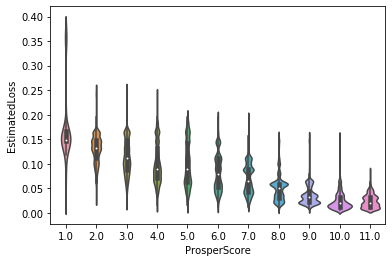

In [308]:
sns.violinplot(x=df_clean['ProsperScore'], y=df_clean['EstimatedLoss']);

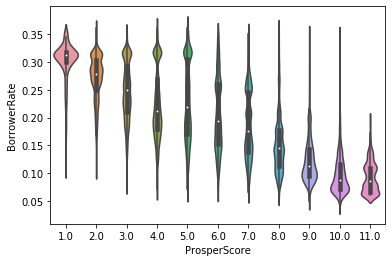

In [311]:
sns.violinplot(x=df_clean['ProsperScore'], y=df_clean['BorrowerRate']);

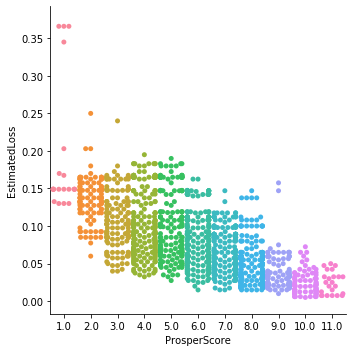

In [315]:
sns.catplot(x="ProsperScore", y="EstimatedLoss", kind="swarm",data=df_clean.sample(2000));

In [61]:
df_clean.loc[df_clean['ProsperScore'] == 11,'ProsperScore'] = 10.0

In [322]:
df_clean['ProsperScore'] = pd.Categorical(df_clean['ProsperScore'])
df_clean['ProsperScore'].head()

0    NaN
1    7.0
2    NaN
3    9.0
4    4.0
Name: ProsperScore, dtype: category
Categories (10, float64): [1.0, 2.0, 3.0, 4.0, ..., 7.0, 8.0, 9.0, 10.0]

- `ListingCategory` deve ser categórica. Poderia criar uma nova coluna com as categorias ou substituir esta coluna com os nomes das categorias.

In [325]:
df_clean.rename(columns={"ListingCategory (numeric)": "ListingCategoryNumeric"},inplace=True)

In [343]:
cats = """ 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7 - Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans"""

In [351]:
dict_listing_cat = {}
for part in cats.split(','):
    list_cat_key = part.split(' - ')[0]
    list_cat_value = part.split(' - ')[1]
    dict_listing_cat[int(list_cat_key)] = list_cat_value

In [353]:
df_clean['ListingCategory'] = df_clean['ListingCategoryNumeric'].map(dict_listing_cat)

In [354]:
df_clean['ListingCategory'].head()

0       Not Available
1    Home Improvement
2       Not Available
3          Motorcycle
4    Home Improvement
Name: ListingCategory, dtype: object

- `DateCreditPulled` converter para datetime.

In [359]:
df_clean['DateCreditPulled'] = pd.to_datetime(df_clean['DateCreditPulled'])

In [360]:
df_clean['DateCreditPulled'].describe()

count                         113937
unique                        112992
top              2013-12-23 09:38:12
freq                               6
first     2005-11-09 00:30:04.487000
last             2014-03-10 12:20:56
Name: DateCreditPulled, dtype: object

- `FirstRecordedCreditLine` converter para datetime.

In [361]:
df_clean['FirstRecordedCreditLine'] = pd.to_datetime(df_clean['FirstRecordedCreditLine'])
df_clean['FirstRecordedCreditLine'].describe()

count                  113240
unique                  11585
top       1993-12-01 00:00:00
freq                      185
first     1947-08-24 00:00:00
last      2012-12-22 00:00:00
Name: FirstRecordedCreditLine, dtype: object

- Salvando alterações

In [62]:
df_clean.to_csv('df_clean2.csv',index=False)

In [2]:
df_clean = pd.read_csv('df_clean.csv')
df_clean.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,EEYDiffEL,ListingCategory,BorrowerStateName,LP_CusPaySum,IncomeRangeMin,IncomeRangeMax
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00.000,0.16516,0.1580,0.1380,...,0,0,0.0,258,NaN,Not Available,Colorado,11396.14,"25,000","49,999"
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0,0,0.0,1,0.05470,Home Improvement,Colorado,0.00,"50,000","74,999"
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00.000,0.28269,0.2750,0.2400,...,0,0,0.0,41,NaN,Not Available,Georgia,4186.63,Not displayed,Not displayed
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,0,0,0.0,158,0.06000,Motorcycle,Georgia,5143.20,"25,000","49,999"
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,0,0,0.0,20,0.09066,Home Improvement,Minnesota,2819.85,"100,000+","100,000+"


- `LoanKey` removendo os registros duplicados.

In [41]:
df_clean.drop_duplicates(['LoanKey'],inplace=True)

In [44]:
(df_clean['LoanKey'].duplicated()).sum()

0

In [46]:
df_clean['ListingNumber'].duplicated().sum()

0

- `LoanOriginationDate` converter para datetime.

In [47]:
df_clean['LoanOriginationDate'] = pd.to_datetime(df_clean['LoanOriginationDate'])

In [50]:
df_clean['LoanOriginationDate'].dt.year.head()

0    2007
1    2014
2    2007
3    2012
4    2013
Name: LoanOriginationDate, dtype: int64

- `LoanOriginationQuarter` Extrair a informação do trimestre e transformá-la esta variável em categórica.

In [54]:
df_clean['LoanOriginationQuarter'] = df_clean['LoanOriginationQuarter'].apply(lambda text:text.split(' ')[0])

In [55]:
df_clean['LoanOriginationQuarter'] = pd.Categorical(df_clean['LoanOriginationQuarter'])
df_clean['LoanOriginationQuarter'].head()

0    Q3
1    Q1
2    Q1
3    Q4
4    Q3
Name: LoanOriginationQuarter, dtype: category
Categories (4, object): [Q1, Q2, Q3, Q4]

- `LP_CustomerPayments` Corrigir valor negativo.
- `LP_InterestandFees` Corrigir valores negativos.
- `LP_CustomerPrincipalPayments` + `LP_InterestandFees` = `LP_CustomerPayments`

In [74]:
df_clean['LP_CustomerPayments'].nsmallest()

28384   -2.3499
1        0.0000
34       0.0000
65       0.0000
86       0.0000
Name: LP_CustomerPayments, dtype: float64

In [65]:
df_clean['LP_InterestandFees'].nsmallest()

28384   -2.3499
91184   -0.0034
1        0.0000
34       0.0000
65       0.0000
Name: LP_InterestandFees, dtype: float64

In [85]:
LP_list = ['LoanOriginalAmount','LP_CustomerPayments','LP_InterestandFees','LP_CustomerPrincipalPayments',\
           'LP_GrossPrincipalLoss','LP_ServiceFees','LP_CollectionFees']

In [86]:
df_clean.loc[df_clean['LP_InterestandFees'].nsmallest().index][LP_list]

,LoanOriginalAmount,LP_CustomerPayments,LP_InterestandFees,LP_CustomerPrincipalPayments,LP_GrossPrincipalLoss,LP_ServiceFees,LP_CollectionFees
28384,3000,-2.3499,-2.3499,0.0,3000.0,0.0,-0.4
91184,3500,3499.9966,-0.0034,3500.0,0.0,0.0,0.0
1,10000,0.0000,0.0000,0.0,0.0,0.0,0.0
34,10000,0.0000,0.0000,0.0,0.0,0.0,0.0
65,15000,0.0000,0.0000,0.0,0.0,0.0,0.0


In [89]:
df_clean['LP_CusPaySum'] = df_clean['LP_InterestandFees']+df_clean['LP_CustomerPrincipalPayments']

In [90]:
df_clean[['LP_CustomerPayments','LP_CusPaySum','LP_InterestandFees','LP_CustomerPrincipalPayments','LP_GrossPrincipalLoss']].sample(10)

,LP_CustomerPayments,LP_CusPaySum,LP_InterestandFees,LP_CustomerPrincipalPayments,LP_GrossPrincipalLoss
14456,2432.3200,2432.3200,957.8200,1474.50,0.0
53160,845.6134,845.6134,475.3234,370.29,0.0
74764,995.4000,995.4000,334.3600,661.04,0.0
101016,4758.2600,4758.2600,1439.1600,3319.10,0.0
8550,716.9878,716.9878,302.4678,414.52,0.0
63405,1584.3000,1584.3000,964.8000,619.50,0.0
8301,4040.6400,4040.6400,1553.5300,2487.11,0.0
96775,9440.6400,9440.6400,573.4100,8867.23,0.0
13469,2770.5800,2770.5800,713.6900,2056.89,0.0
46133,1989.4926,1989.4926,512.8926,1476.60,0.0


- `IncomeRange` separar os valores em duas novas colunas

In [99]:
list(df_clean['IncomeRange'].unique())

['$25,000-49,999',
 '$50,000-74,999',
 'Not displayed',
 '$100,000+',
 '$75,000-99,999',
 '$1-24,999',
 'Not employed',
 '$0']

In [116]:
def separate_incomerange(incomerange):
    if('$' in incomerange):
        temp_list = incomerange.replace('$','').split('-')
        if(len(temp_list) == 2):
            return temp_list[0],temp_list[1]
        else:
            return temp_list[0],temp_list[0]
    else:
        return incomerange,incomerange

In [108]:
df_clean['IncomeRangeMin'] = df_clean['IncomeRange']
df_clean['IncomeRangeMax'] = df_clean['IncomeRange']

In [122]:
df_clean['IncomeRangeMin'],df_clean['IncomeRangeMax'] = zip(*df_clean['IncomeRange'].apply(separate_incomerange))

In [125]:
df_clean[['IncomeRange','IncomeRangeMin','IncomeRangeMax']].head()

,IncomeRange,IncomeRangeMin,IncomeRangeMax
0,"$25,000-49,999","25,000","49,999"
1,"$50,000-74,999","50,000","74,999"
2,Not displayed,Not displayed,Not displayed
3,"$25,000-49,999","25,000","49,999"
4,"$100,000+","100,000+","100,000+"


In [152]:
df_clean['IncomeRangeMin'] = pd.Categorical(df_clean['IncomeRangeMin'],ordered=True,
               categories=['Not displayed', 'Not employed', '0', '1', '25,000', '50,000', '75,000', '100,000+'])

In [153]:
df_clean['IncomeRangeMax'] = pd.Categorical(df_clean['IncomeRangeMax'],ordered=True,
              categories=['Not displayed', 'Not employed','0','24,999','49,999','74,999','99,999','100,000+'])

- Salvando os dados limpos 

In [137]:
df_clean.to_csv('df_clean.csv',index=False)

In [2]:
df_clean = pd.read_csv('df_clean.csv')

In [5]:
df_clean.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,EEYDiffEL,ListingCategory,BorrowerStateName,LP_CusPaySum,IncomeRangeMin,IncomeRangeMax
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14 00:00:00.000,0.16516,0.1580,0.1380,...,0,0,0.0,258,NaN,Not Available,Colorado,11396.14,"25,000","49,999"
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0,0,0.0,1,0.05470,Home Improvement,Colorado,0.00,"50,000","74,999"
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17 00:00:00.000,0.28269,0.2750,0.2400,...,0,0,0.0,41,NaN,Not Available,Georgia,4186.63,Not displayed,Not displayed
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,0,0,0.0,158,0.06000,Motorcycle,Georgia,5143.20,"25,000","49,999"
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,0,0,0.0,20,0.09066,Home Improvement,Minnesota,2819.85,"100,000+","100,000+"


### 5. Exploratory Data Analysis

<ol>
    <li>Qual o valor médio dos empréstimos de cada categoria?</li>
    <li>Os riscos calculados (ProsperScore) são eficientes?</li>
<ol>

#### 5.1. Dates

In [4]:
df_clean = pd.read_csv('df_clean.csv')
df_clean['ListingCreationDate'] = pd.to_datetime(df_clean['ListingCreationDate'])
#The date the listing was created
df_clean['ClosedDate'] = pd.to_datetime(df_clean['ClosedDate'])
#applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses.
df_clean['DateCreditPulled'] = pd.to_datetime(df_clean['DateCreditPulled'])
#The date the credit profile was pulled.
df_clean['FirstRecordedCreditLine'] = pd.to_datetime(df_clean['FirstRecordedCreditLine'])
#The date the first credit line was opened.
df_clean['LoanOriginationDate'] = pd.to_datetime(df_clean['LoanOriginationDate'])
#The date the loan was originated.

In [44]:
p1 = df_clean.groupby([df_clean['ListingCreationDate'].dt.year,df_clean['ListingCreationDate'].dt.month]).size()

In [53]:
p3 = df_clean.groupby([df_clean['ClosedDate'].dt.year,df_clean['ClosedDate'].dt.month]).size()

In [57]:
p4 = df_clean.groupby([df_clean['DateCreditPulled'].dt.year,df_clean['DateCreditPulled'].dt.month]).size()

In [45]:
p2 = df_clean.groupby([df_clean['LoanOriginationDate'].dt.year,df_clean['LoanOriginationDate'].dt.month]).size()

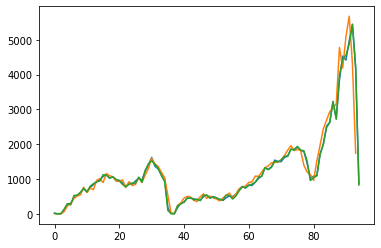

In [58]:
plt.plot(p1.values)
plt.plot(p2.values)
plt.plot(p4.values)

- `ListingCreationDate`, `DateCreditPulled` e  `LoanOriginationDate` possuem as datas praticamente iguais. Ou seja, assim que é realizado o registro do empréstimo, o perfil do empréstimo também é criado e realizado.

#### 5.2. CreditGrade and ProsperRating

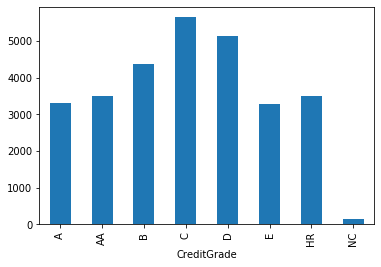

In [62]:
df_clean.groupby('CreditGrade').size().plot.bar()

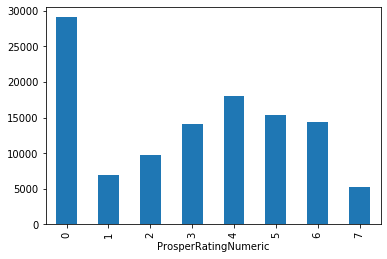

In [63]:
df_clean.groupby('ProsperRatingNumeric').size().plot.bar()

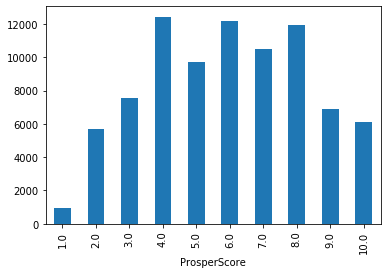

In [68]:
df_clean.groupby('ProsperScore').size().plot.bar()

#### 5.3. ListingCategory

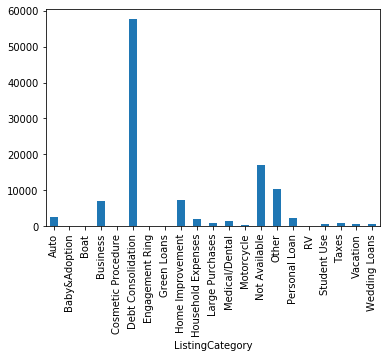

In [71]:
df_clean.groupby(['ListingCategory']).size().plot.bar()

- Consolidação de débitos é o principal destino do empréstimo, seguido de `Not Available` e `Other`.

In [32]:
p1 = df_clean.groupby(['Occupation']).size().sort_values(ascending=False)

In [33]:
p1

Occupation
Other                                 28422
Professional                          13531
Computer Programmer                    4442
Executive                              4280
Teacher                                3729
Administrative Assistant               3677
Analyst                                3578
Sales - Commission                     3414
Accountant/CPA                         3209
Clerical                               3135
Sales - Retail                         2780
Skilled Labor                          2723
Retail Management                      2579
Nurse (RN)                             2475
Construction                           1777
Truck Driver                           1666
Laborer                                1578
Police Officer/Correction Officer      1561
Civil Service                          1445
Engineer - Mechanical                  1397
Military Enlisted                      1265
Food Service Management                1227
Engineer - Electrical

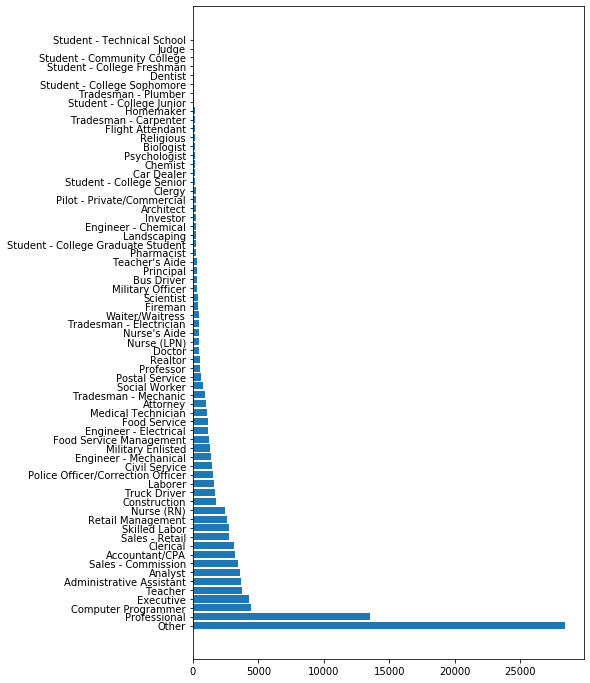

In [34]:
plt.figure(figsize=(7,12))
plt.barh(p1.index,p1.values)
plt.show()

- Os estudantes são os que menos solicitam empréstimos. Ocupações como `Other` e `Professional` são vagas. Há duas ocupações que me chamaram atenção: `Computer Programmer` e `Teacher`. Essas duas ocupações solicitam empréstimos para que objetivos? Essas ocupações querem investir em suas carreiras, pagar dívidas, abrir um negócio ou outra objetivo? 

In [134]:
df_occ = df_clean[df_clean['Occupation'].isin(['Computer Programmer','Teacher','Executive'])]

In [103]:
df_occ.pivot_table(index='Occupation',columns='ListingCategory',aggfunc='size')

ListingCategory,Auto,Baby&Adoption,Boat,Business,Cosmetic Procedure,Debt Consolidation,Engagement Ring,Green Loans,Home Improvement,Household Expenses,...,Medical/Dental,Motorcycle,Not Available,Other,Personal Loan,RV,Student Use,Taxes,Vacation,Wedding Loans
Occupation,,,,,,,,,,,,,,,,,,,,,
Computer Programmer,101.0,6.0,4.0,331.0,2.0,2151.0,10.0,2.0,324.0,67.0,...,45.0,9.0,723.0,401.0,103.0,3.0,21.0,39.0,25.0,35.0
Executive,55.0,6.0,6.0,444.0,1.0,2296.0,11.0,1.0,384.0,59.0,...,70.0,12.0,417.0,299.0,68.0,1.0,11.0,52.0,18.0,27.0
Teacher,71.0,17.0,NaN,169.0,2.0,2027.0,2.0,1.0,246.0,91.0,...,66.0,5.0,424.0,390.0,84.0,2.0,36.0,21.0,27.0,35.0


- Dessas três categorias, o objetivo do empréstimo na maioria das vezes é para `Debt Concolidation`, seguido de `Not Available` e `Other`. O `Teacher` tem mais chance de investir o empréstimo em `Student Use` que em `Business`, enquanto que o `Computer Programmer` e `Executive` ocorre o contrário. Os gastos com a casa e com a família também estão entre os maiores.

In [67]:
t = df_clean.pivot_table(index='Occupation',columns='ListingCategory',aggfunc='size')

In [76]:
t.index,t.columns

(Index(['Accountant/CPA', 'Administrative Assistant', 'Analyst', 'Architect',
        'Attorney', 'Biologist', 'Bus Driver', 'Car Dealer', 'Chemist',
        'Civil Service', 'Clergy', 'Clerical', 'Computer Programmer',
        'Construction', 'Dentist', 'Doctor', 'Engineer - Chemical',
        'Engineer - Electrical', 'Engineer - Mechanical', 'Executive',
        'Fireman', 'Flight Attendant', 'Food Service',
        'Food Service Management', 'Homemaker', 'Investor', 'Judge', 'Laborer',
        'Landscaping', 'Medical Technician', 'Military Enlisted',
        'Military Officer', 'Nurse (LPN)', 'Nurse (RN)', 'Nurse's Aide',
        'Other', 'Pharmacist', 'Pilot - Private/Commercial',
        'Police Officer/Correction Officer', 'Postal Service', 'Principal',
        'Professional', 'Professor', 'Psychologist', 'Realtor', 'Religious',
        'Retail Management', 'Sales - Commission', 'Sales - Retail',
        'Scientist', 'Skilled Labor', 'Social Worker',
        'Student - College Fr

In [99]:
data = []
for occupation in list(t.index):
    data.append((t.loc[occupation] >= t.loc[occupation,'Debt Consolidation']).values)
    #print((t.loc[occupation] >= t.loc[occupation,'Debt Consolidation']).values)
    #t.index[list((t.loc[occupation] >= t.loc[occupation,'Debt Consolidation']))]

In [100]:
pd.DataFrame(data,index=t.index,columns=t.columns)

ListingCategory,Auto,Baby&Adoption,Boat,Business,Cosmetic Procedure,Debt Consolidation,Engagement Ring,Green Loans,Home Improvement,Household Expenses,...,Medical/Dental,Motorcycle,Not Available,Other,Personal Loan,RV,Student Use,Taxes,Vacation,Wedding Loans
Occupation,,,,,,,,,,,,,,,,,,,,,
Accountant/CPA,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Administrative Assistant,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Analyst,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Architect,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Attorney,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Biologist,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Bus Driver,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Car Dealer,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Chemist,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
t1 = df_clean.pivot_table(index='Occupation',columns='ListingCategory',aggfunc='size')

In [105]:
t1.ge(t1['Debt Consolidation'],axis=0)

ListingCategory,Auto,Baby&Adoption,Boat,Business,Cosmetic Procedure,Debt Consolidation,Engagement Ring,Green Loans,Home Improvement,Household Expenses,...,Medical/Dental,Motorcycle,Not Available,Other,Personal Loan,RV,Student Use,Taxes,Vacation,Wedding Loans
Occupation,,,,,,,,,,,,,,,,,,,,,
Accountant/CPA,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Administrative Assistant,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Analyst,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Architect,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Attorney,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Biologist,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Bus Driver,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Car Dealer,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Chemist,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
t1.loc[t1.ge(t1['Debt Consolidation'],axis=0)['Not Available']].index

Index(['Homemaker', 'Realtor', 'Student - College Freshman',
       'Student - College Graduate Student', 'Student - College Junior',
       'Student - College Senior', 'Student - College Sophomore',
       'Student - Community College', 'Student - Technical School'],
      dtype='object', name='Occupation')

- As `Occupation`:  `Homemaker`, `Realtor`, `Student - College Freshman`, `Student - College Graduate Student`, `Student - College Junior`, `Student - College Senior`, `Student - College Sophomore`, `Student - Community College`, `Student - Technical School` usam o empréstimo para na categoria `Not Available`. Enquanto demais `Occupation` usam seu empréstimo em ` Debt Consolidation`.

In [123]:
df_occ.pivot_table(index='Occupation',columns='ProsperScore',aggfunc='size')

ProsperScore,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
Occupation,,,,,,,,,,
Computer Programmer,37,133,186,284,278,385,381,582,439,495
Executive,33,158,233,393,333,419,439,575,387,467
Teacher,31,189,268,403,362,469,347,419,222,148


In [64]:
df_clean = pd.read_csv('df_clean2.csv')

In [77]:
t = df_clean.pivot_table(index='Occupation',values='ProsperScore',columns=['ProsperRatingNumeric'],aggfunc=np.mean)

In [99]:
t.reindex(t.sort_values(by=[7,6,5,4,3,2,1],ascending=True).index)

ProsperRatingNumeric,0,1,2,3,4,5,6,7
Occupation,,,,,,,,
Bus Driver,0.0,3.545455,3.270270,4.660377,5.546875,6.878788,8.281250,8.000000
Student - College Graduate Student,0.0,4.076923,4.933333,6.052632,6.161290,6.400000,8.521739,8.000000
Realtor,0.0,2.928571,2.851064,4.600000,4.796296,5.657143,7.583333,8.444444
Nurse (LPN),0.0,3.750000,3.911111,4.918367,5.406977,6.370370,7.614035,8.571429
Teacher's Aide,0.0,3.628571,3.895833,5.205882,6.028571,6.000000,7.526316,8.600000
Laborer,0.0,3.544643,3.835897,4.714876,5.386282,6.463415,7.746479,8.629630
Psychologist,0.0,2.625000,3.714286,5.117647,5.285714,5.391304,7.863636,8.818182
Nurse's Aide,0.0,3.612245,3.474576,4.524390,5.363636,6.370370,7.620690,8.857143
Food Service,0.0,3.608247,3.475524,4.891892,5.022599,6.350515,7.738318,8.913043


In [114]:
df_clean[df_clean['Occupation'].str.contains('Student',case=False,na=False)].groupby('Occupation').size()

Occupation
Student - College Freshman             41
Student - College Graduate Student    245
Student - College Junior              111
Student - College Senior              187
Student - College Sophomore            69
Student - Community College            28
Student - Technical School             16
dtype: int64

- As `Occupation` que estão relacionadas à `Student` têm bons `Scores`. Talvez porque há políticas de empréstimos para facilitar crédito para `Student`. No entanto, `Student - College Graduate Student` possui um dos piores `Score`. 
- Nesta última tabela é possível identificar que há poucos registos com as `Occupation` `Student - College Freshman`, `Student - College Sophomore`, `Student - Community College` e `Student - Technical School`. Enquanto que `Student - College Graduate Student`, `Student - College Junior` e `Student - College Senior` possuem 245, 111 e 187 registros respectivamente.

#### - Mas porque `Student - College Graduate Student` possui avaliação pior que demais classes de estudantes?

In [132]:
t = df_clean[df_clean['ProsperRatingNumeric'] >= 4].pivot_table(index='Occupation',\
    values=['CreditScoreRangeLower','CreditScoreRangeUpper'],columns='ProsperRatingNumeric',aggfunc=np.mean)
t.reindex(t['CreditScoreRangeUpper'].sort_values(by=[7,6,5,4],ascending=True).index)


CreditScoreRangeLower              \
ProsperRatingNumeric                                   4           5   
Occupation                                                             
Homemaker                                     692.727273  710.000000   
Student - College Senior                      697.142857  706.666667   
Car Dealer                                    691.034483  696.521739   
Waiter/Waitress                               691.525424  700.512821   
Realtor                                       697.037037  712.571429   
Truck Driver                                  682.823529  701.853282   
Student - College Graduate Student            692.903226  698.000000   
Student - College Junior                      680.000000  760.000000   
Religious                                     683.157895  712.631579   
Nurse's Aide                                  691.313131  711.481481   
Tradesman - Electrician                       683.870968  701.428571   
Nurse (RN)                                    690.289256  708.080357   
Retail Management                             688.843537  702.989130   
Architect                                     690.588235  710.370370   
Biologist                                     697.647059  726.666667   
Food Service                                  687.457627  702.061856   
Psychologist                                  692.142857  701.739130   
Clerical                                      691.468254  699.810726   
Administrative Assistant                      692.432432  710.444965   
Tradesman - Mechanic                          684.951456  698.192771   
Military Enlisted                             689.638554  708.141593   
Chemist                                       686.400000  701.904762   
Skilled Labor                                 686.330645  701.030445   
Pilot - Private/Commercial                    689.600000  715.625000   
Teacher's Aide                                685.714286  709.565217   
Social Worker                                 684.148148  703.148148   
Medical Technician                            692.277228  706.987952   
Teacher                                       693.706070  710.727969   
Landscaping                                   679.512195  704.285714   
Analyst                                       687.821229  705.106383   
...                                                  ...         ...   
Postal Service                                685.000000  707.088608   
Engineer - Mechanical                         690.850202  709.545455   
Computer Programmer                           688.630849  705.348101   
Civil Service                                 690.597015  708.571429   
Sales - Commission                            687.425150  704.255319   
Engineer - Electrical                         686.751592  706.326531   
Professional                                  689.302744  707.249874   
Principal                                     688.928571  714.642857   
Investor                                      692.352941  726.666667   
Attorney                                      690.125000  710.062112   
Accountant/CPA                                687.448015  708.611111   
Sales - Retail                                693.516209  703.364486   
Nurse (LPN)                                   686.976744  707.654321   
Military Officer                              696.956522  704.864865   
Laborer                                       690.036101  701.951220   
Doctor                                        689.722222  717.882353   
Clergy                                        694.814815  710.833333   
Fireman                                       693.947368  713.617021   
Scientist                                     684.905660  709.666667   
Pharmacist                                    704.545455  717.142857   
Tradesman - Plumber                           684.444444  711.250000   
Judge                                         640.000000  680.000000   
Eng

In [203]:
t = df_clean.pivot_table(index='Occupation',values='ProsperRatingNumeric',columns=['IncomeRangeMin','IncomeRangeMax'],\
                     aggfunc=np.mean).drop(columns=['Not displayed','Not employed'])
t.reindex(t.loc[:,'100,000+'].sort_values(by='100,000+',ascending=False).index)

IncomeRangeMin,0,1,"25,000","50,000","75,000","100,000+"
IncomeRangeMax,0,"24,999","49,999","74,999","99,999","100,000+"
Occupation,,,,,,
Judge,NaN,4.000000,5.000000,6.000000,1.000000,5.500000
Nurse's Aide,NaN,2.116071,3.003311,3.166667,3.900000,5.000000
Professor,NaN,2.000000,2.695122,3.750000,4.053846,4.862595
Postal Service,0.000000,0.909091,2.275510,3.379227,3.606061,4.857143
Engineer - Chemical,1.500000,1.333333,2.714286,2.660377,3.960784,4.595960
Scientist,0.000000,1.727273,2.887640,3.918367,3.963415,4.492537
Engineer - Mechanical,1.000000,2.500000,2.922078,3.478261,3.867008,4.457237
Pharmacist,NaN,NaN,3.100000,3.750000,3.235294,4.432558


- À medida que aumenta o `IncomeRange` o `ProsperRatingNumeric` também aumenta.

In [254]:
t = df_clean.pivot_table(index='Occupation',values=['CurrentCreditLines','TotalCreditLinespast7years'],columns=['IncomeRangeMin','IncomeRangeMax'],\
                     aggfunc=np.mean)
t.reindex(t.loc[:,'TotalCreditLinespast7years'].loc[:,'0'].sort_values(by='0',ascending=False).index)

CurrentCreditLines                          \
IncomeRangeMin                         Not displayed Not employed          0   
IncomeRangeMax                         Not displayed Not employed          0   
Occupation                                                                     
Doctor                                           NaN          NaN  19.000000   
Accountant/CPA                              8.333333          NaN  18.000000   
Landscaping                                 6.000000          NaN  17.000000   
Attorney                                   25.000000          NaN  10.833333   
Student - Community College                 7.000000    11.000000  10.000000   
Analyst                                    10.400000    11.000000  11.500000   
Retail Management                          10.500000     7.000000  12.000000   
Clerical                                    4.000000          NaN  10.666667   
Principal                                        NaN          NaN  10.000000   
Military Enlisted                           7.000000          NaN  10.000000   
Postal Service                             23.000000          NaN   2.000000   
Nurse (RN)                                  9.000000          NaN  18.000000   
Sales - Commission                         13.400000     2.000000  10.970588   
Realtor                                    10.500000          NaN  11.250000   
Scientist                                        NaN          NaN  18.000000   
Dentist                                          NaN          NaN  10.000000   
Food Service Management                          NaN          NaN   9.571429   
Computer Programmer                         5.000000          NaN   9.727273   
Sales - Retail                              7.500000     1.000000   9.722222   
Pilot - Private/Commercial                       NaN          NaN  10.000000   
Professional                                9.857143     9.000000   9.171429   
Construction                                8.000000          NaN   8.923077   
Other                                       9.269231     7.418182   9.188612   
Food Service                                5.000000          NaN   8.500000   
Executive                                  13.000000          NaN   7.769231   
Homemaker                                        NaN     9.125000  10.000000   
Medical Technician                         14.000000          NaN   8.500000   
Teacher                                    10.500000          NaN   9.000000   
Teacher's Aide                                   NaN    11.000000   6.333333   
Social Worker                                    NaN          NaN   9.000000   
...                                              ...          ...        ...   
Engineer - Chemical                              NaN          NaN   7.500000   
Tradesman - Carpenter                            NaN          NaN   5.000000   
Tradesman - Mechanic                             NaN          NaN   5.400000   
Skilled Labor                               7.750000     5.000000   4.000000   
Student - College Junior                    4.000000     2.500000   6.300000   
Engineer - Electrical                       5.000000          NaN   6.000000   
Engineer - Mechanical                      14.000000          NaN   5.000000   
Tradesman - Electrician                          NaN          NaN   1.000000   
Waiter/Waitress                            15.000000     4.000000   3.888889   
Truck Driver                                5.666667          NaN   0.000000   
Student - College Sophomore                 1.000000     2.000000   3.750000   
Student - College Freshman                       NaN     4.000000   1.000000   
Tradesman - Plumber                        13.000000          NaN   2.500000   
Religious                                        NaN          NaN   0.000000   
Architect                                        NaN          NaN        NaN   
Biologist                         

- Quem recebe `0` de renda possue maior número de `CreditLines`.

In [272]:
t_column = '100,000+'
t = df_clean.pivot_table(index='Occupation',values='OpenRevolvingAccounts',columns=['IncomeRangeMin','IncomeRangeMax'],\
                     aggfunc=np.mean,margins=True)
t.reindex(t.sort_values(by='All',ascending=False).index)

IncomeRangeMin,Not displayed,Not employed,0,1,"25,000","50,000","75,000","100,000+",All
IncomeRangeMax,Not displayed,Not employed,0,"24,999","49,999","74,999","99,999","100,000+",
Occupation,,,,,,,,,
Judge,NaN,NaN,NaN,7.000000,18.000000,3.000000,0.000000,10.333333,9.727273
Pharmacist,4.400000,NaN,NaN,NaN,4.400000,11.250000,6.058824,9.600000,9.109804
Attorney,8.062500,NaN,5.833333,NaN,6.870370,7.456790,8.604651,9.148270,8.620523
Nurse (RN),6.020408,NaN,18.000000,7.937500,6.451282,8.125514,8.789617,9.658824,8.467071
Psychologist,15.000000,30.000000,6.666667,5.500000,6.210526,7.547170,9.593750,9.233333,8.447552
Principal,6.250000,NaN,8.666667,9.000000,5.350000,8.192982,8.132812,9.617021,8.400651
Executive,7.184049,NaN,5.769231,5.454545,6.385593,7.410819,8.353535,8.970886,8.368925
Doctor,7.375000,NaN,12.000000,5.333333,5.589744,6.412698,7.729730,9.087349,8.298780


- Os `Students`são so que menos têm contas com capital de giro.

In [301]:
t_column = '0'
t = df_clean.pivot_table(index='Occupation',values=['InquiriesLast6Months','TotalInquiries'],columns=['ProsperRatingNumeric'],\
                     aggfunc=np.mean,margins=True)
t#t.reindex(t.loc[:,'TotalInquiries'].loc[:,t_column].sort_values(by=t_column,ascending=False).index)

InquiriesLast6Months                      \
ProsperRatingNumeric                                  0         1         2   
Occupation                                                                    
Accountant/CPA                                 2.939210  1.965909  1.411765   
Administrative Assistant                       2.912641  1.639881  1.441176   
Analyst                                        2.532333  2.180556  1.551724   
Architect                                      2.750000  1.875000  2.000000   
Attorney                                       2.516667  2.205128  1.508772   
Biologist                                      2.133333  1.857143  0.800000   
Bus Driver                                     3.646154  2.681818  1.162162   
Car Dealer                                     3.054054  2.454545  1.842105   
Chemist                                        2.111111  3.333333  2.777778   
Civil Service                                  2.889937  2.227273  1.578125   
Clergy                                         1.948718  1.739130  1.000000   
Clerical                                       3.272815  1.415459  1.153153   
Computer Programmer                            2.331719  2.276316  2.083004   
Construction                                   3.367171  1.961905  1.291391   
Dentist                                        4.750000  2.500000  1.000000   
Doctor                                         3.574257  1.538462  2.269231   
Engineer - Chemical                            2.469388  2.000000  2.142857   
Engineer - Electrical                          2.893333  2.789474  2.028169   
Engineer - Mechanical                          2.162963  2.543860  1.715789   
Executive                                      3.131829  2.354037  2.024221   
Fireman                                        2.563107  2.875000  1.512195   
Flight Attendant                               2.694444  0.625000  1.800000   
Food Service                                   2.096429  1.659794  1.174825   
Food Service Management                        3.051282  1.825000  1.591667   
Homemaker                                      2.854839  1.545455  0.909091   
Investor                                       1.923077  1.208333  1.538462   
Judge                                               NaN  1.000000  2.000000   
Laborer                                        2.650667  1.687500  1.210256   
Landscaping                                    2.593750  1.133333  0.896552   
Medical Technician                             2.774336  1.825000  1.355769   
...                                                 ...       ...       ...   
Police Officer/Correction Officer              3.338870  2.483516  1.888060   
Postal Service                                 2.628571  1.611111  2.246377   
Principal                                      3.100000  2.222222  1.346154   
Professional                                   3.112119  2.125000  1.692449   
Professor                                      2.666667  2.615385  1.638889   
Psychologist                                   3.222222  1.000000  1.285714   
Realtor                                        3.831034  1.642857  0.978723   
Religious                                      1.774194  1.444444  1.181818   
Retail Management                              2.963272  2.027211  1.393574   
Sales - Commission                             3.244261  1.805556  1.582143   
Sales - Retail                                 2.577982  1.897959  1.335294   
Scientist                                      2.139241  2.578947  1.200000   
Skilled Labor                                  2.562278  1.725000  1.360870   
Social Worker                                  2.710843  1.878049  1.396552   
Student - College Freshman                     2.833333  0.333333  0.333333   
Student - College Graduate Student             1.248120  1.000000  0.866667   
Student - College Junior                       1.831325  1.375000  0.500000   
Studen

- `ProsperRatingNumeric` é influenciado pelo número de `InqueriesLast6Months` e `TotalInquiries`. Quanto maior o número de `Inquires` menor o `Rating`.

In [349]:
t_column = 'All'
t = df_clean.pivot_table(index='Occupation',values=['AmountDelinquent'],columns=['ProsperRatingNumeric'],\
                     aggfunc=max,margins=True)
t.reindex(t.loc[:,'AmountDelinquent'].loc[:,t_column].sort_values(ascending=False).index)

AmountDelinquent                      \
ProsperRatingNumeric                              0         1         2   
Occupation                                                                
All                                        444745.0  249209.0  463881.0   
Engineer - Electrical                       95320.0   23960.0  463881.0   
Professional                               444745.0  249209.0  108415.0   
Sales - Commission                          93593.0  119147.0  225595.0   
Investor                                   112684.0   68123.0     409.0   
Police Officer/Correction Officer           70334.0   35727.0   37936.0   
Nurse (RN)                                  40527.0  120153.0   70659.0   
Realtor                                     81004.0   33628.0   54915.0   
Other                                      190585.0  202741.0  230291.0   
Clerical                                    39210.0   52844.0   80441.0   
Food Service                                27883.0   22882.0   48487.0   
Civil Service                               16159.0   66600.0   61350.0   
Analyst                                     33036.0  176347.0   48024.0   
Accountant/CPA                              48673.0   39379.0   36514.0   
Executive                                   64538.0   45202.0  172240.0   
Doctor                                       5138.0    4878.0   24150.0   
Tradesman - Carpenter                        8718.0    1431.0    5549.0   
Administrative Assistant                   160039.0   43093.0   93237.0   
Waiter/Waitress                             77853.0   13466.0    6973.0   
Retail Management                           40013.0   54918.0  153237.0   
Construction                                66852.0   11858.0  109956.0   
Tradesman - Mechanic                        55958.0    9795.0   72997.0   
Pharmacist                                  17860.0   20533.0   11926.0   
Social Worker                               29809.0   12241.0  124651.0   
Postal Service                              24351.0   54550.0   56743.0   
Bus Driver                                  25280.0     270.0  126830.0   
Food Service Management                     62512.0   19738.0   73118.0   
Car Dealer                                  12439.0  120642.0   15392.0   
Tradesman - Plumber                          3225.0  119660.0     100.0   
Truck Driver                                58521.0   53442.0   44036.0   
...                                             ...       ...       ...   
Tradesman - Electrician                     30239.0   10877.0   32969.0   
Teacher                                     82580.0   74844.0   41378.0   
Laborer                                     18037.0   12977.0   15684.0   
Skilled Labor                               43776.0   72051.0   64519.0   
Principal                                   19498.0   26107.0   70456.0   
Military Officer                             5848.0   11914.0   68304.0   
Attorney                                    38660.0   24089.0   24280.0   
Nurse (LPN)                                 17895.0   50385.0    6547.0   
Engineer - Chemical                         32254.0       0.0   19090.0   
Dentist                                      3471.0       0.0    3048.0   
Scientist                                    9273.0    2369.0   23066.0   
Landscaping                                 34183.0     326.0   12195.0   
Fireman                                      3985.0   14129.0   12676.0   
Biologist                                   12104.0   24270.0    3674.0   
Teacher's Aide                              27719.0   18723.0   37316.0   
Student - College Graduate Student          37077.0    1164.0       0.0   
Architect                                   14750.0    9700.0       0.0   
Student - College Freshman                   1107.0     189.0       0.0   
Pilot - Private/Commercial                  31115.0     181.0    4219.0   
Nurse's Aide                                10641.0   25307.

- Não há `Judge` inadiplente.
- Quando maior o `Rating` menor a quantidade de `Delinquencies`.

In [350]:
df_clean['DelinquenciesLast7Years']

0          4.0
1          0.0
2          0.0
3         14.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9         28.0
10         1.0
11         0.0
12         0.0
13         0.0
14         0.0
15        12.0
16         0.0
17         0.0
18         0.0
19         0.0
20         5.0
21         0.0
22         0.0
23         8.0
24         4.0
25         0.0
26         0.0
27         0.0
28         0.0
29        10.0
          ... 
113036     0.0
113037     0.0
113038     0.0
113039     7.0
113040    48.0
113041     0.0
113042     0.0
113043    16.0
113044     9.0
113045    18.0
113046     0.0
113047     0.0
113048     0.0
113049     3.0
113050     NaN
113051     0.0
113052     0.0
113053     2.0
113054     0.0
113055    18.0
113056     0.0
113057     0.0
113058     9.0
113059     0.0
113060     0.0
113061     7.0
113062     4.0
113063     0.0
113064     0.0
113065     3.0
Name: DelinquenciesLast7Years, Length: 113066, dtype: float64